In [1]:
import pandas as pd
import numpy as np
from scipy.stats import zscore
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.preprocessing import StandardScaler
from sklearn.neighbors import KNeighborsClassifier
from sklearn.metrics import confusion_matrix, classification_report
from sklearn.metrics import accuracy_score
from sklearn.tree import DecisionTreeClassifier
from sklearn.utils import shuffle
import warnings
warnings.filterwarnings('ignore')

In [2]:
drug = pd.read_csv("DIA_trainingset_RDKit_descriptors.csv")
drug.head()

Label                                             SMILES  BalabanJ  \
0      0  COC(=O)N(C)c1c(N)nc(nc1N)c2nn(Cc3ccccc3F)c4ncc...     1.821   
1      0                    C[C@H](N(O)C(=O)N)c1cc2ccccc2s1     2.363   
2      0                              C[N+](C)(C)CC(=O)[O-]     3.551   
3      1  CC(C)n1c(\C=C\[C@H](O)C[C@H](O)CC(=O)O)c(c2ccc...     2.076   
4      1           C\C(=C(\C#N)/C(=O)Nc1ccc(cc1)C(F)(F)F)\O     2.888   

    BertzCT    Chi0   Chi0n   Chi0v    Chi1  Chi1n  Chi1v  ...  fr_sulfide  \
0  1266.407  22.121  16.781  16.781  14.901  9.203  9.203  ...           0   
1   490.434  11.707   8.752   9.569   7.592  4.854  5.670  ...           0   
2    93.092   6.784   5.471   5.471   3.417  2.420  2.420  ...           0   
3  1053.003  21.836  16.995  16.995  14.274  9.926  9.926  ...           0   
4   549.823  14.629   9.746   9.746   8.752  5.040  5.040  ...           0   

   fr_sulfonamd  fr_sulfone  fr_term_acetylene  fr_tetrazole  fr_thiazole  \
0             0           0                  0             0            0   
1             0           0                  0             0            0   
2             0           0                  0             0            0   
3             0           0                  0             0            0   
4             0           0                  0             0            0   

   fr_thiocyan  fr_thiophene  fr_unbrch_alkane  fr_urea  
0            0             0                 0        0  
1            0             1                 0        1  
2            0             0                 0        0  
3            0             0                 0        0  
4            0             0                 0        0  

[5 rows x 198 columns]

In [3]:
drug.shape

(477, 198)

In [4]:
drug.info

<bound method DataFrame.info of      Label                                             SMILES  BalabanJ  \
0        0  COC(=O)N(C)c1c(N)nc(nc1N)c2nn(Cc3ccccc3F)c4ncc...     1.821   
1        0                    C[C@H](N(O)C(=O)N)c1cc2ccccc2s1     2.363   
2        0                              C[N+](C)(C)CC(=O)[O-]     3.551   
3        1  CC(C)n1c(\C=C\[C@H](O)C[C@H](O)CC(=O)O)c(c2ccc...     2.076   
4        1           C\C(=C(\C#N)/C(=O)Nc1ccc(cc1)C(F)(F)F)\O     2.888   
..     ...                                                ...       ...   
472      0                          C(C1=NCCN1)c2cccc3ccccc23     2.022   
473      0  C[N@+]1(CC2CC2)CC[C@]34[C@H]5Oc6c(O)ccc(C[C@@H...     1.602   
474      1  CO\N=C(/C(=O)N[C@H]1[C@H]2SCC(=C(N2C1=O)C(=O)O...     1.766   
475      0   Clc1ccc(CO\N=C(\Cn2ccnc2)/c3ccc(Cl)cc3Cl)c(Cl)c1     1.831   
476      1  CCC[C@@]1(CCc2ccccc2)CC(=C([C@H](CC)c3cccc(c3)...     1.617   

      BertzCT    Chi0   Chi0n   Chi0v    Chi1   Chi1n   Chi1v  ... 

In [5]:
drug.describe

<bound method NDFrame.describe of      Label                                             SMILES  BalabanJ  \
0        0  COC(=O)N(C)c1c(N)nc(nc1N)c2nn(Cc3ccccc3F)c4ncc...     1.821   
1        0                    C[C@H](N(O)C(=O)N)c1cc2ccccc2s1     2.363   
2        0                              C[N+](C)(C)CC(=O)[O-]     3.551   
3        1  CC(C)n1c(\C=C\[C@H](O)C[C@H](O)CC(=O)O)c(c2ccc...     2.076   
4        1           C\C(=C(\C#N)/C(=O)Nc1ccc(cc1)C(F)(F)F)\O     2.888   
..     ...                                                ...       ...   
472      0                          C(C1=NCCN1)c2cccc3ccccc23     2.022   
473      0  C[N@+]1(CC2CC2)CC[C@]34[C@H]5Oc6c(O)ccc(C[C@@H...     1.602   
474      1  CO\N=C(/C(=O)N[C@H]1[C@H]2SCC(=C(N2C1=O)C(=O)O...     1.766   
475      0   Clc1ccc(CO\N=C(\Cn2ccnc2)/c3ccc(Cl)cc3Cl)c(Cl)c1     1.831   
476      1  CCC[C@@]1(CCc2ccccc2)CC(=C([C@H](CC)c3cccc(c3)...     1.617   

      BertzCT    Chi0   Chi0n   Chi0v    Chi1   Chi1n   Chi1v  ..

In [6]:
# all of the columns after checking the description were numerical, so those columns that were not numericals need to be converted 
non_numeric = drug.select_dtypes(exclude = ['int64', 'float64']).columns
print(non_numeric)

Index(['SMILES'], dtype='object')


In [7]:
# only 1 column, which contain chemical formula, since this information is already available in the existing column, we can delete this
drug = drug.drop(columns='SMILES')
drug.shape

(477, 197)

In [8]:
# the first step I thought about after making a cursory check of the data is to remove all variables that show absolutely no variance,
# either all zeroes or all ones.
# these will add no predictive power. 

non_unique = drug.columns[drug.nunique() == 1]
print(non_unique)

Index(['NumRadicalElectrons', 'SMR_VSA8', 'SlogP_VSA9', 'VSA_EState1',
       'VSA_EState2', 'VSA_EState3', 'VSA_EState4', 'VSA_EState5',
       'VSA_EState6', 'VSA_EState7', 'fr_azide', 'fr_barbitur', 'fr_diazo',
       'fr_isocyan', 'fr_isothiocyan', 'fr_prisulfonamd', 'fr_thiocyan'],
      dtype='object')


In [9]:
drug = drug.drop(columns=non_unique)
drug.shape

(477, 180)

In [10]:
drug.isnull().values.any()

False

In [11]:
#converted Label into categorical
drug['Label'] = drug['Label'].astype('category')
drug['Label'].dtypes

CategoricalDtype(categories=[0, 1], ordered=False, categories_dtype=int64)

In [12]:
# now we can check for columns that are highly correlated, multicollinearity can be an issue for the model
corr = drug.drop(columns=['Label']).corr()
print(corr)

                  BalabanJ   BertzCT      Chi0     Chi0n     Chi0v      Chi1  \
BalabanJ          1.000000 -0.605399 -0.491436 -0.543104 -0.524626 -0.569717   
BertzCT          -0.605399  1.000000  0.875140  0.839800  0.848796  0.897471   
Chi0             -0.491436  0.875140  1.000000  0.981936  0.983594  0.990890   
Chi0n            -0.543104  0.839800  0.981936  1.000000  0.989250  0.984737   
Chi0v            -0.524626  0.848796  0.983594  0.989250  1.000000  0.982932   
...                    ...       ...       ...       ...       ...       ...   
fr_tetrazole     -0.086644  0.126904  0.073596  0.072251  0.064050  0.090725   
fr_thiazole      -0.069576  0.120795  0.080169  0.056018  0.083614  0.082778   
fr_thiophene     -0.064205  0.028143 -0.014259 -0.021548  0.006269 -0.005512   
fr_unbrch_alkane  0.107086 -0.079232  0.111531  0.137922  0.130899  0.106022   
fr_urea           0.061479 -0.049023 -0.063688 -0.070533 -0.073792 -0.059101   

                     Chi1n     Chi1v   

Exploration

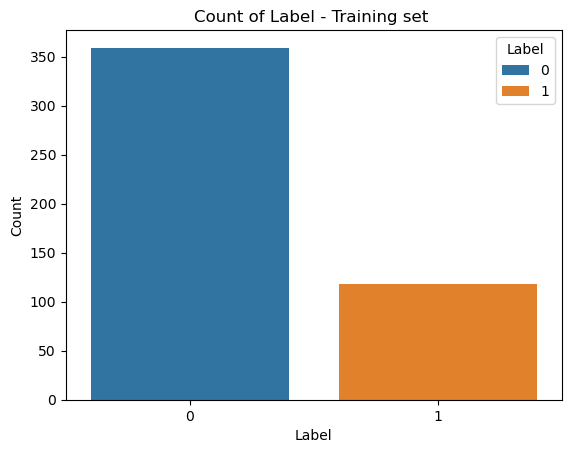

In [14]:
sns.countplot(x='Label', hue='Label', data=drug)
plt.title('Count of Label - Training set ')
plt.ylabel('Count')
plt.legend(title='Label')
plt.show()

In [15]:
drug['Label'].value_counts()

Label
0    359
1    118
Name: count, dtype: int64

In [16]:
#taking out all the column names which contains the word "NUM", because need to convert them to factor - as seen by the data description
NUM_columns = []
for cols in drug.columns:
    if "Num" in cols:
        NUM_columns.append(cols)
chi_columns = []
for cols in drug.columns:
    if "Chi" in cols:
        chi_columns.append(cols)
fr_columns = []
for cols in drug.columns:
    if "fr_" in cols:
        fr_columns.append(cols)
VSA_columns = []
for cols in drug.columns:
    if "VSA" in cols:
        VSA_columns.append(cols)
SlogP_columns = []
for cols in drug.columns:
    if "SlogP" in cols:
        SlogP_columns.append(cols)
SMR_columns = []
for cols in drug.columns:
    if "SMR" in cols:
        SlogP_columns.append(cols)
PEOE_columns = []
for cols in drug.columns:
    if "PEOE" in cols:
        PEOE_columns.append(cols)
Estate_columns = []
for cols in drug.columns:
    if "EState" in cols:
        Estate_columns.append(cols)
charge_columns = []
for cols in drug.columns:
    if "PartialCharge" in cols:
        charge_columns.append(cols)
kappa_columns = []
for cols in drug.columns:
    if "Kappa" in cols:
        kappa_columns.append(cols)

print(kappa_columns)

['Kappa1', 'Kappa2', 'Kappa3']


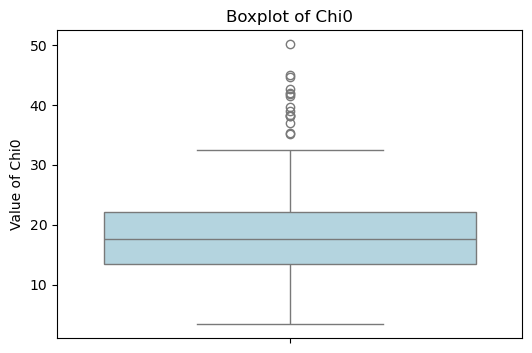

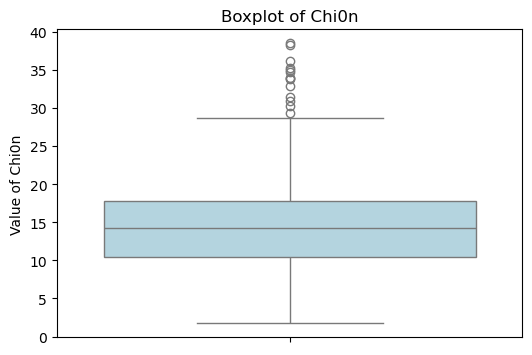

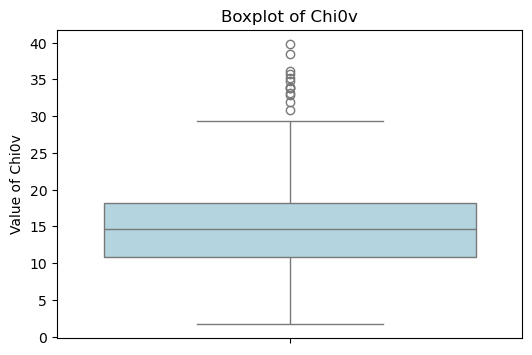

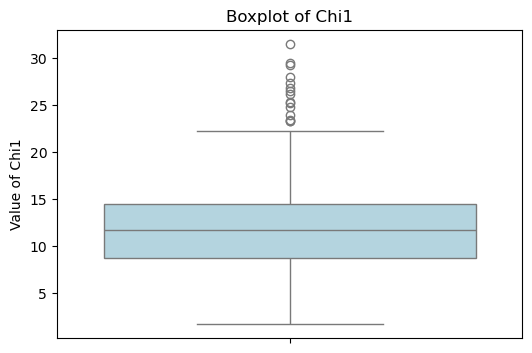

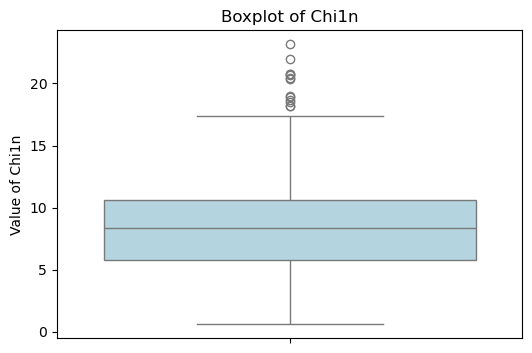

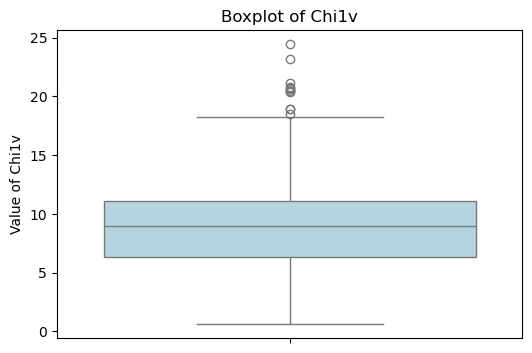

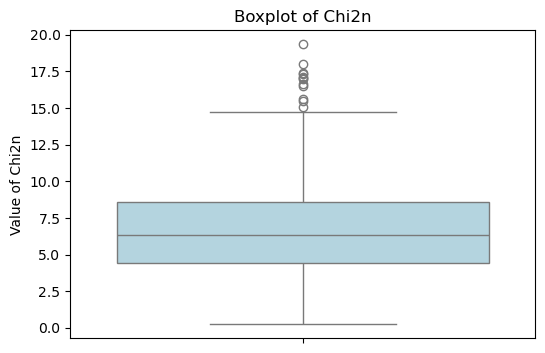

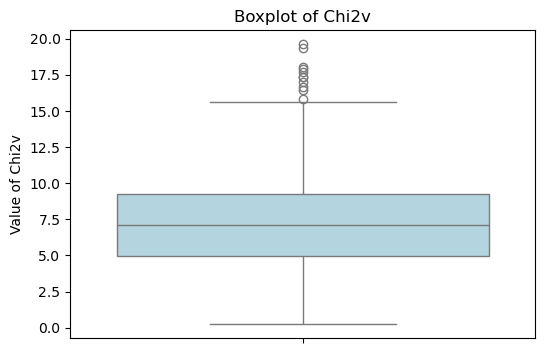

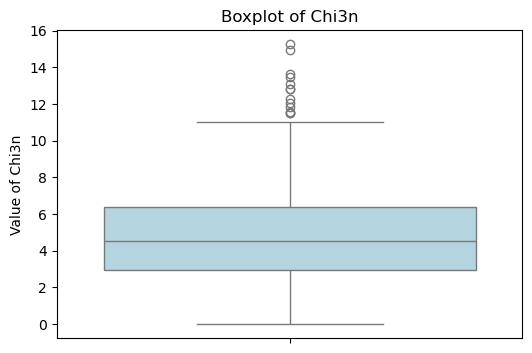

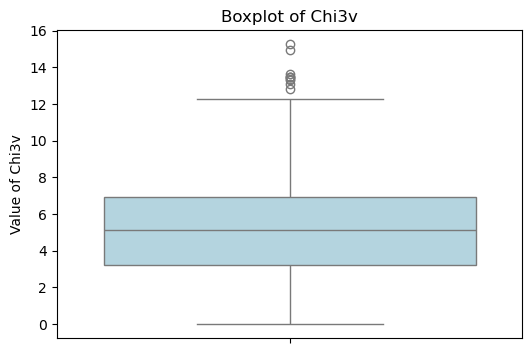

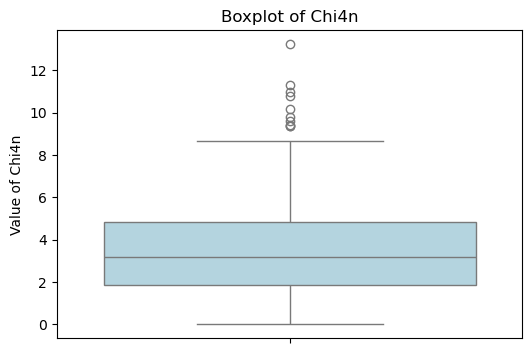

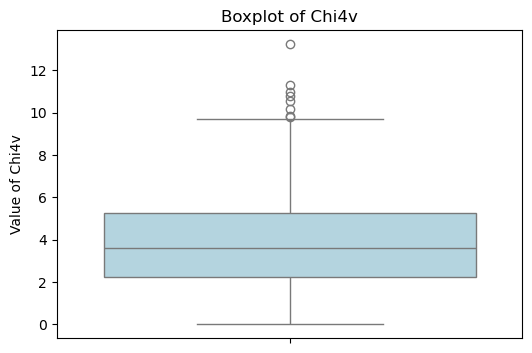

In [17]:
for col in chi_columns:
    plt.figure(figsize=(6, 4))
    sns.boxplot(y=drug[col], color='lightblue')
    plt.title(f'Boxplot of {col}')
    plt.ylabel(f'Value of {col}')
    plt.show()

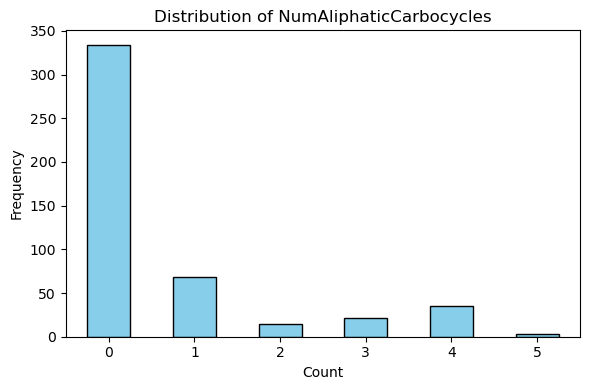

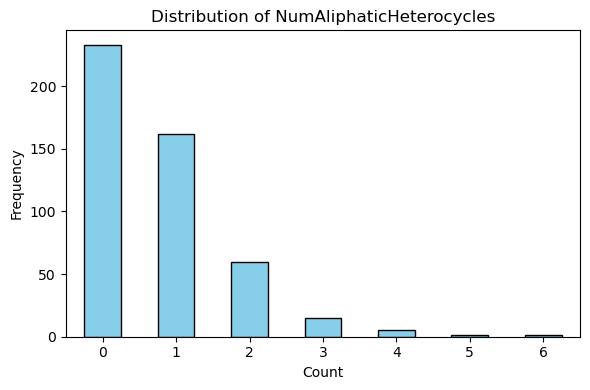

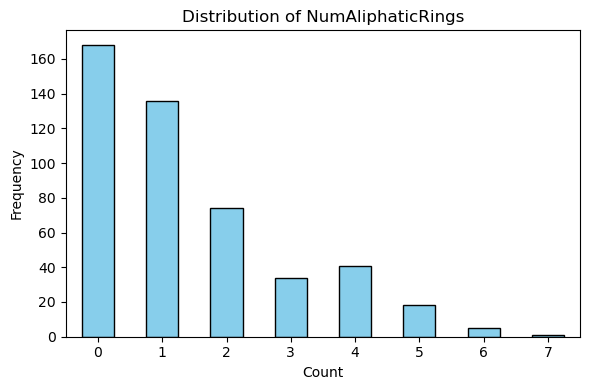

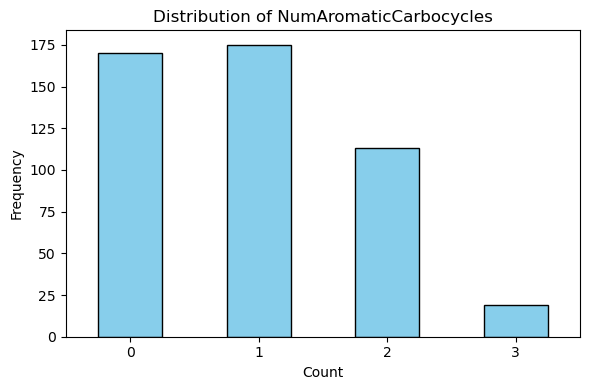

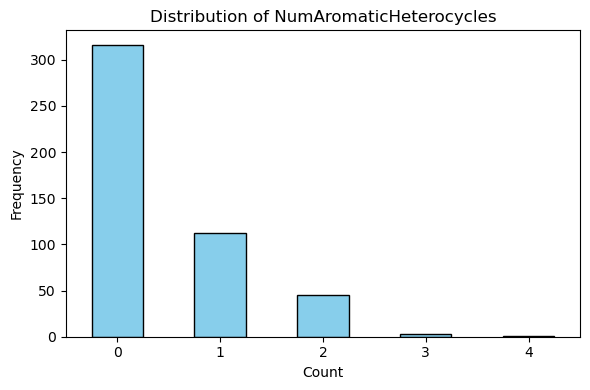

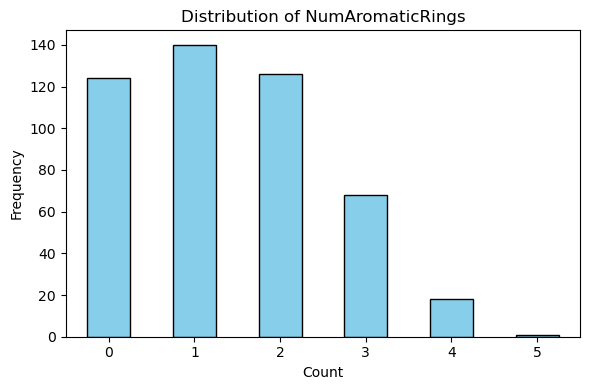

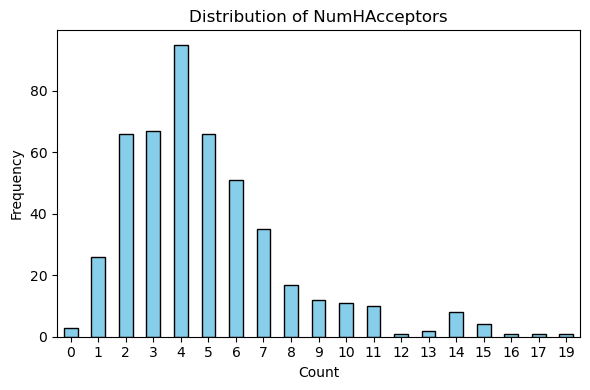

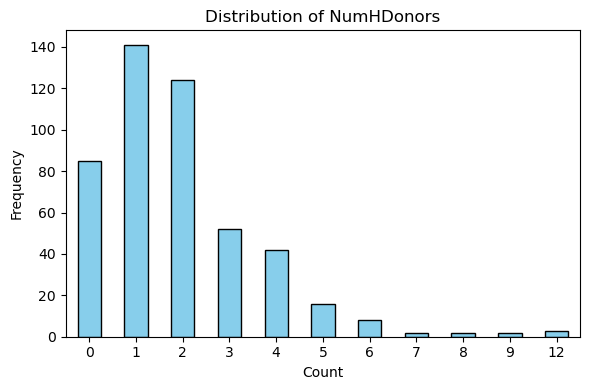

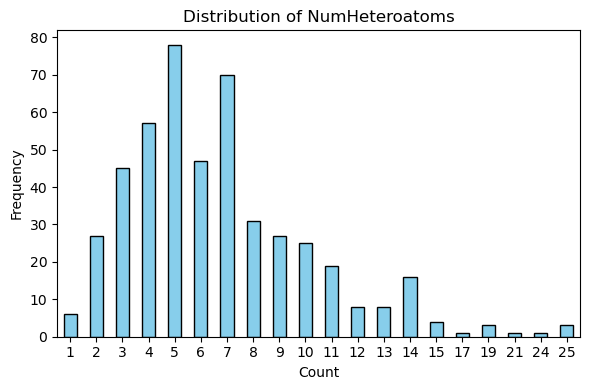

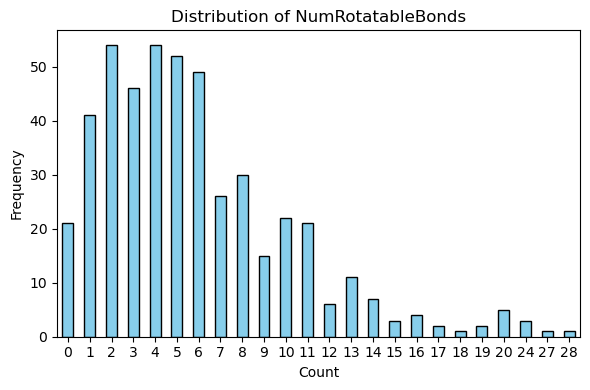

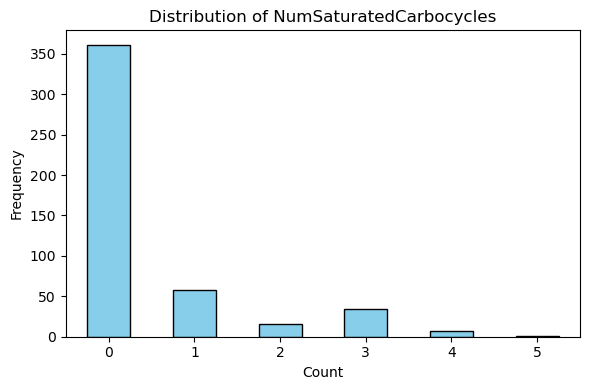

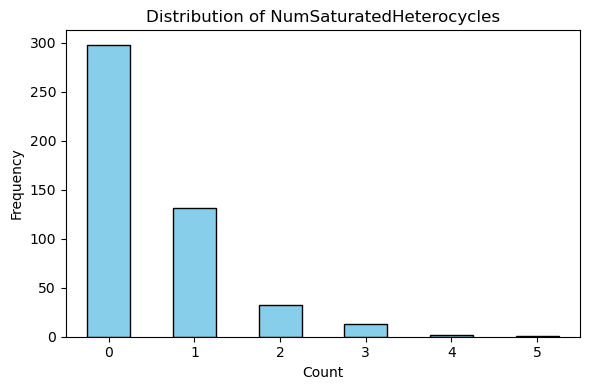

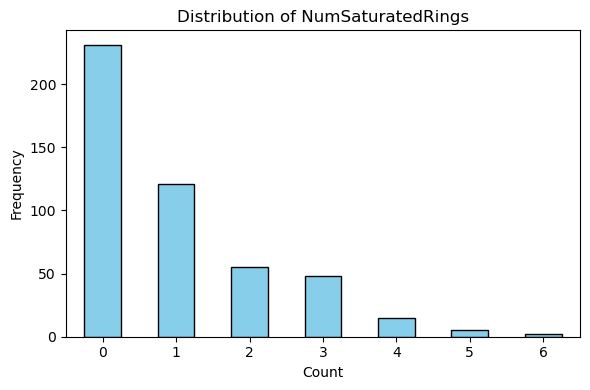

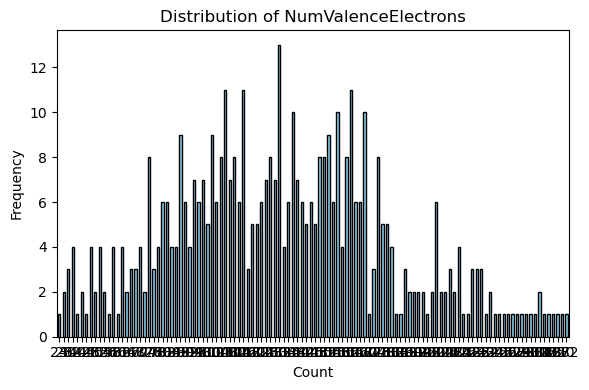

In [18]:
for col in NUM_columns:  # num_cols = list of your 'Num' columns
    plt.figure(figsize=(6, 4))
    drug[col].value_counts().sort_index().plot(kind='bar', color='skyblue', edgecolor='black')
    plt.title(f'Distribution of {col}')
    plt.xlabel('Count')
    plt.ylabel('Frequency')
    plt.xticks(rotation=0)
    plt.tight_layout()
    plt.show()

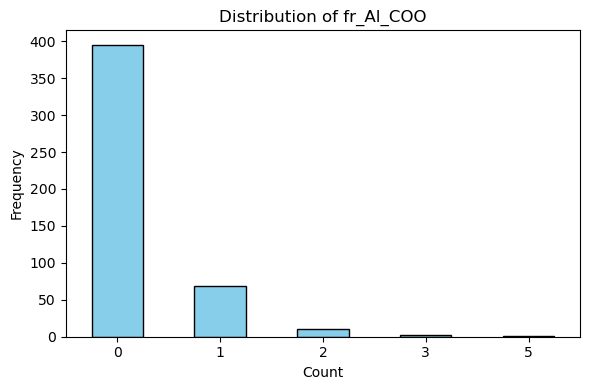

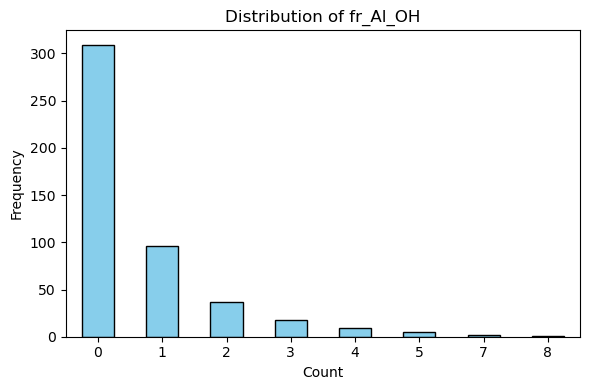

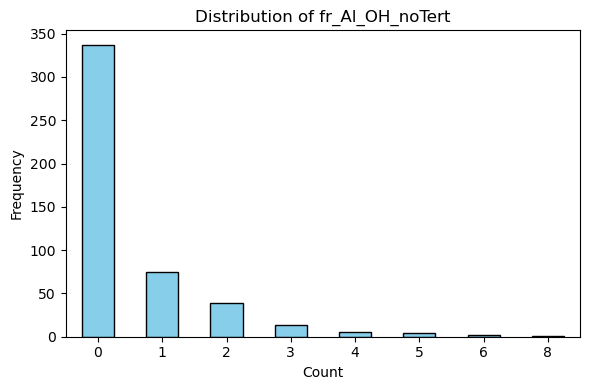

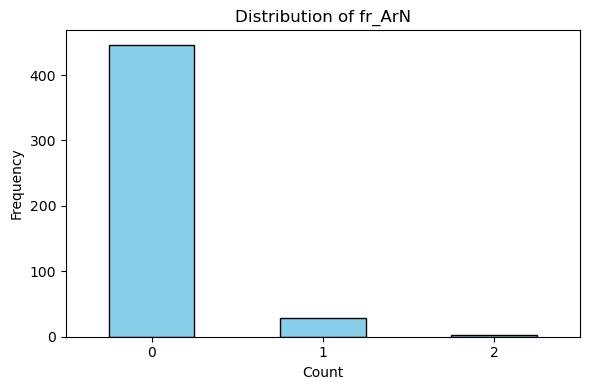

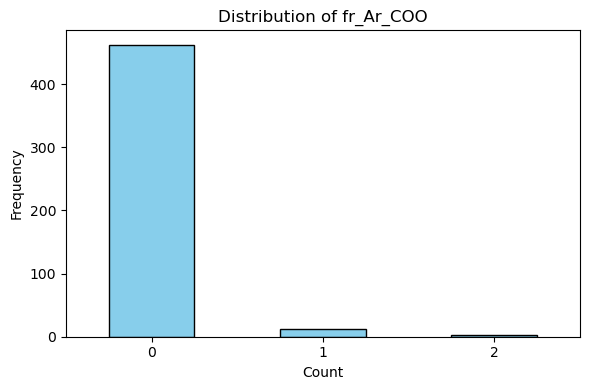

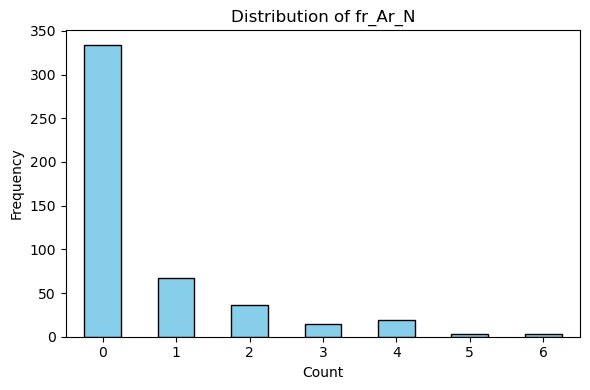

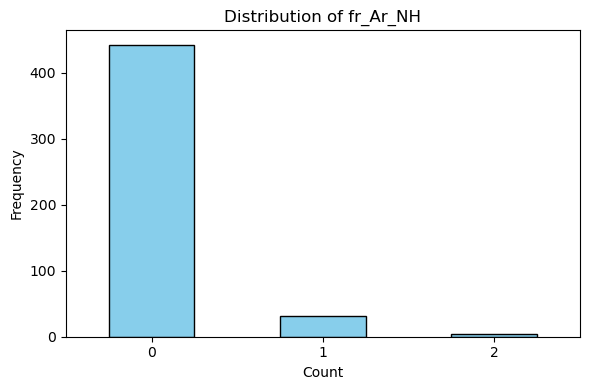

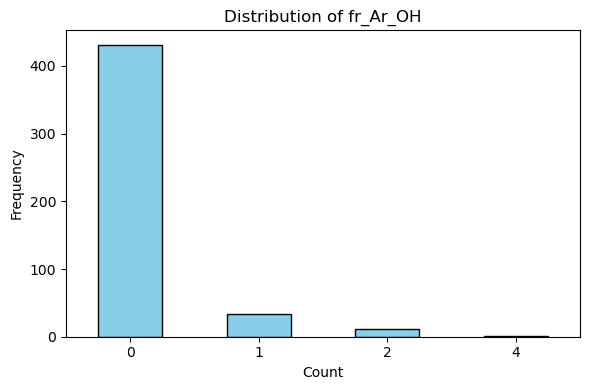

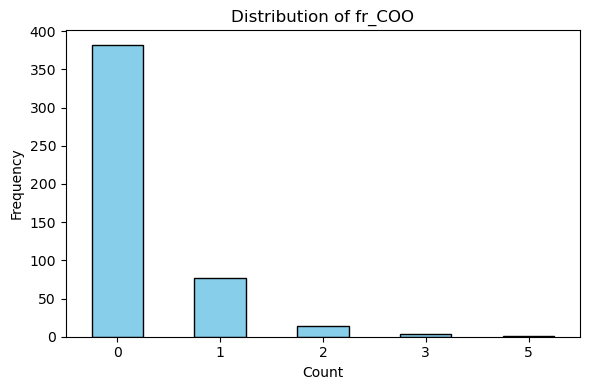

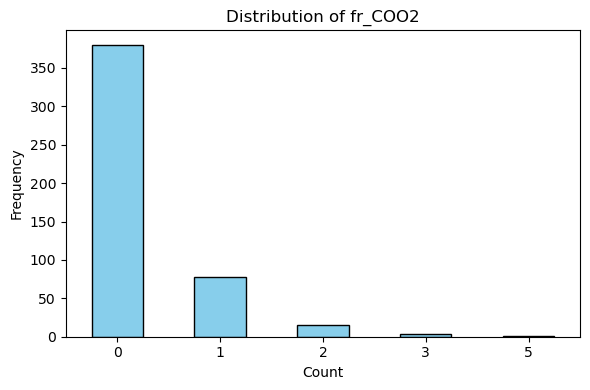

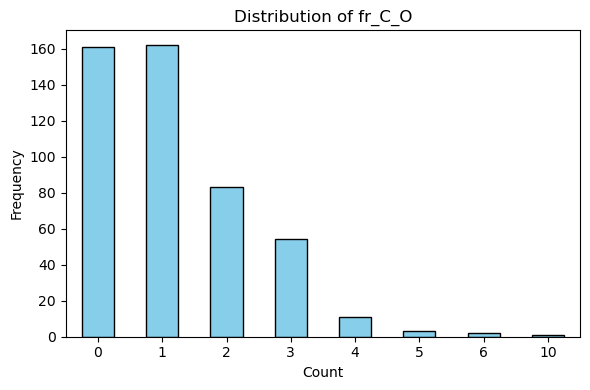

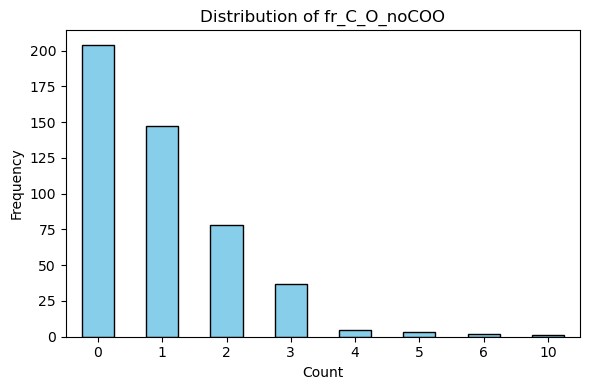

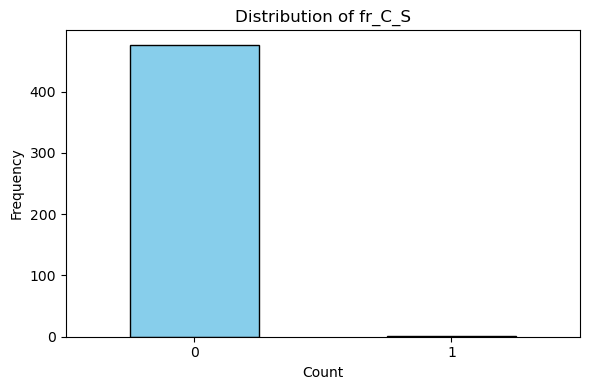

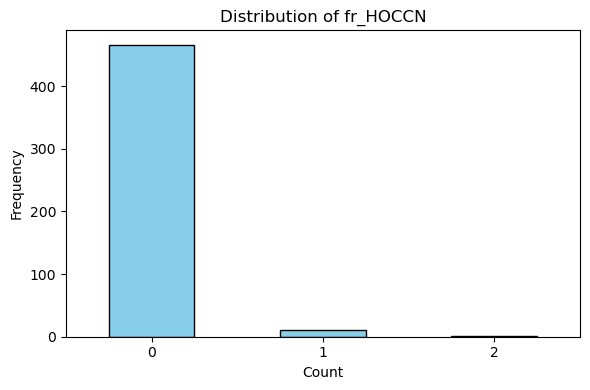

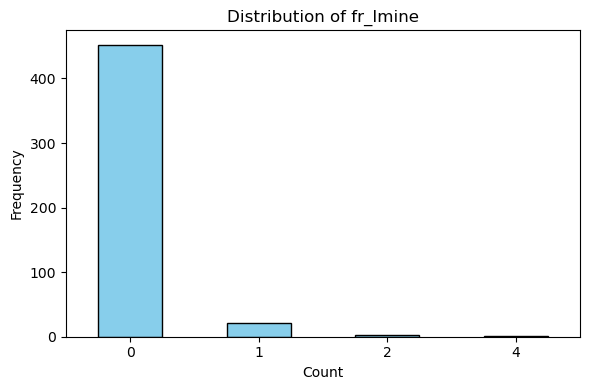

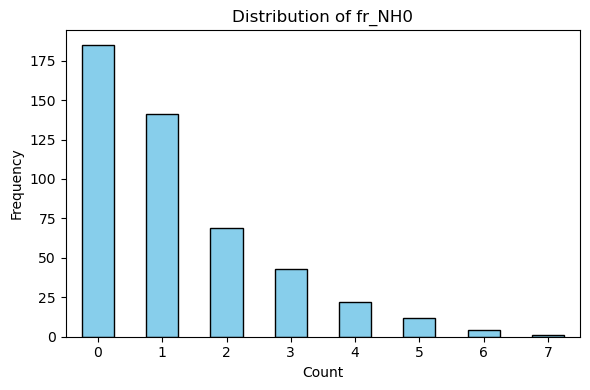

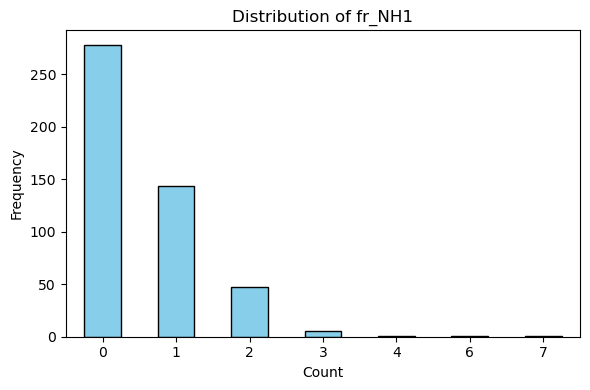

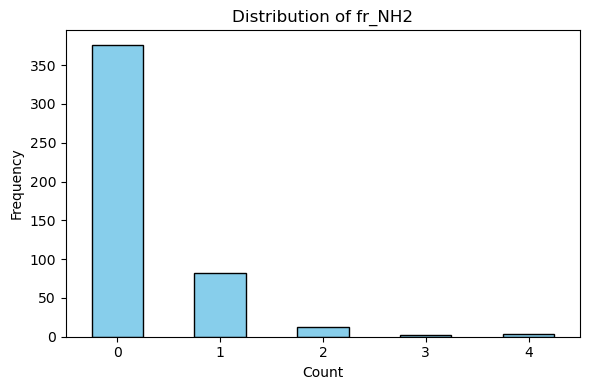

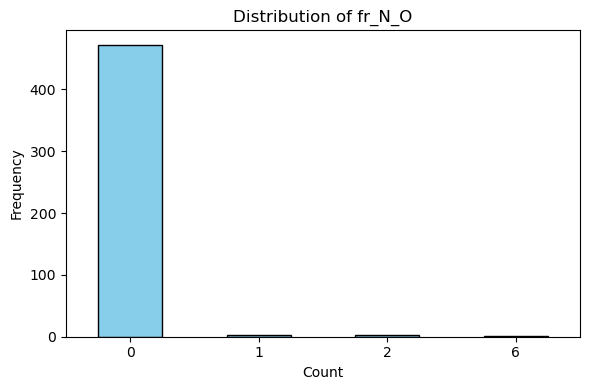

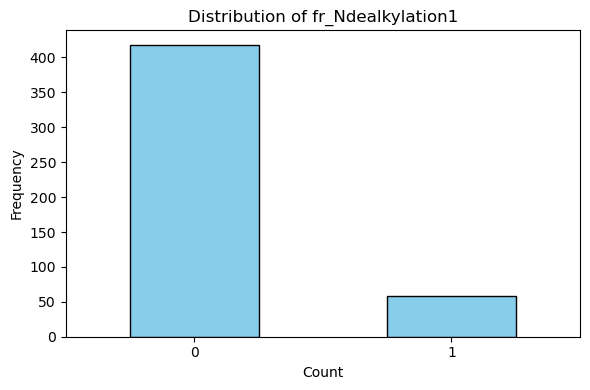

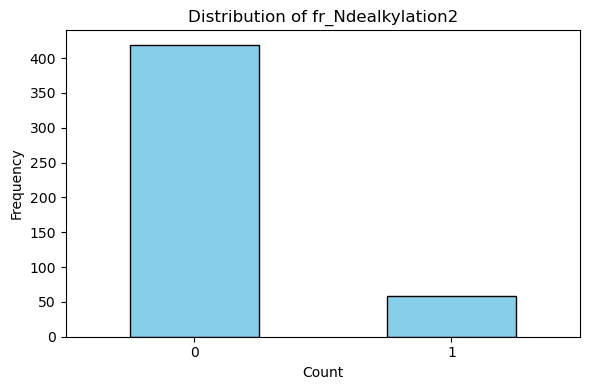

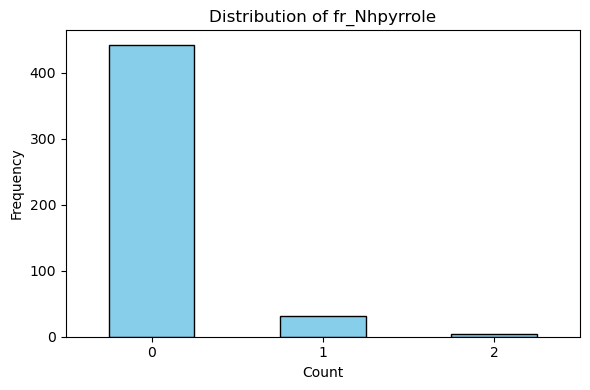

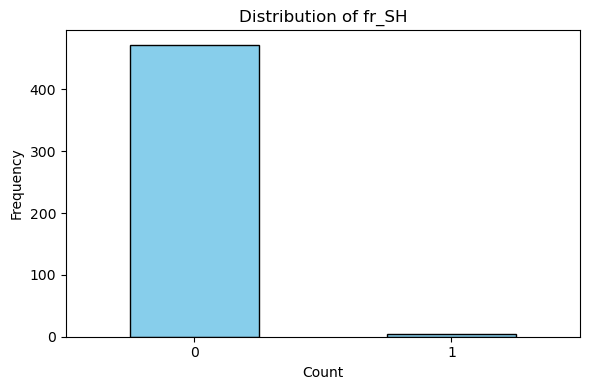

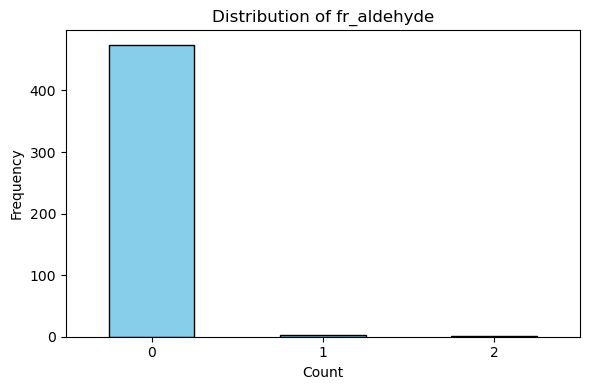

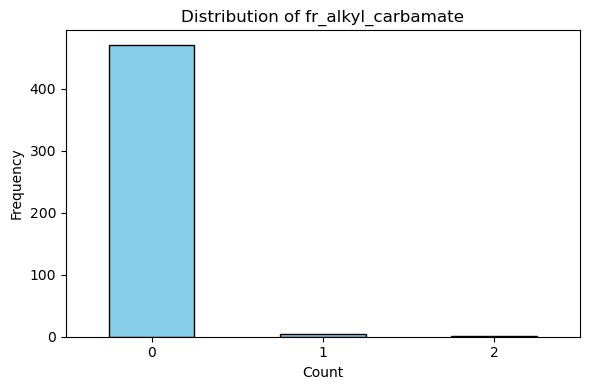

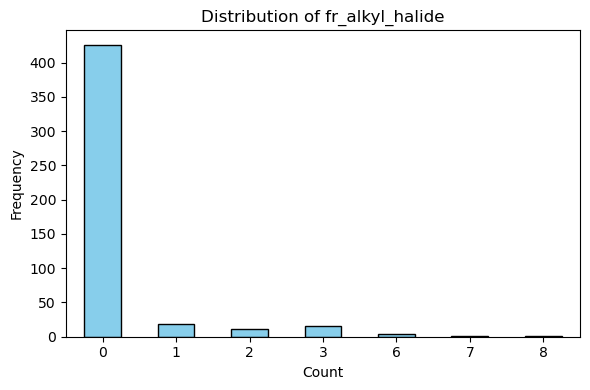

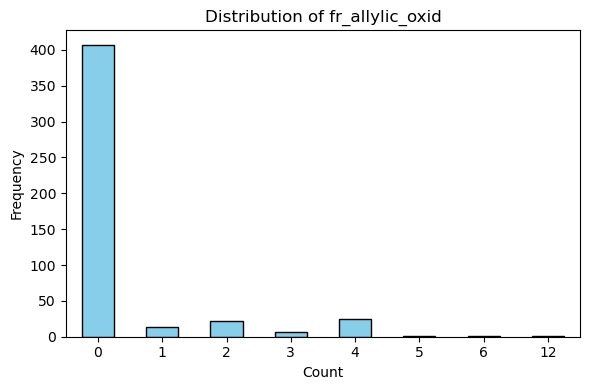

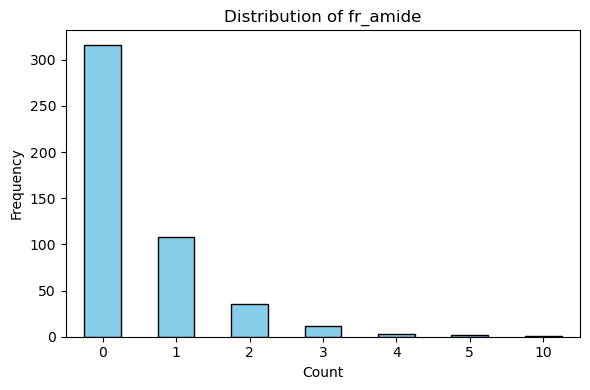

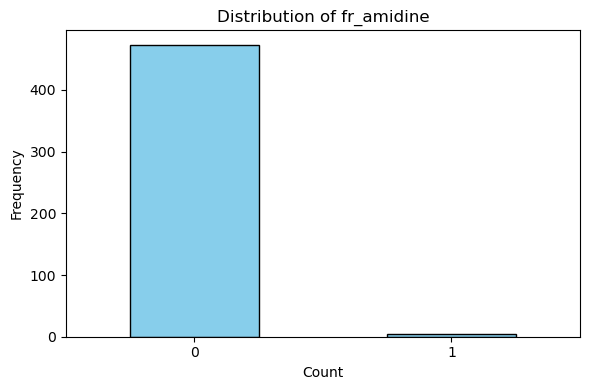

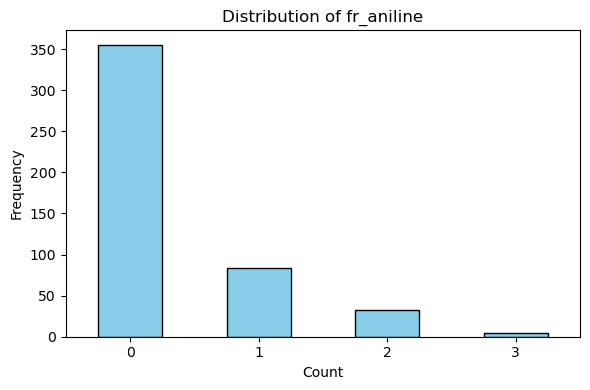

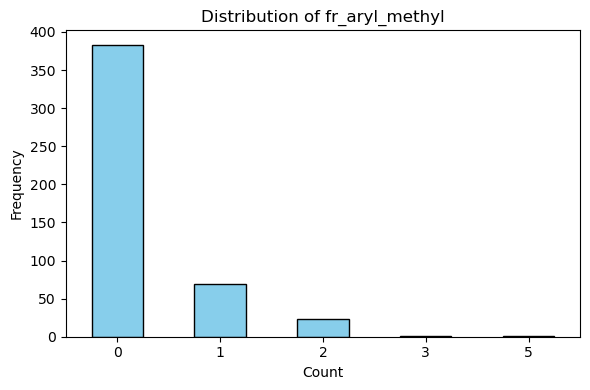

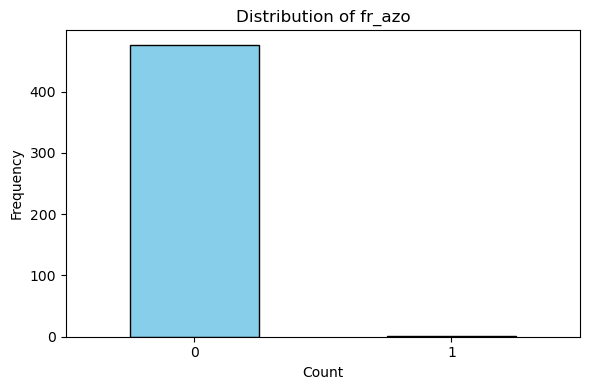

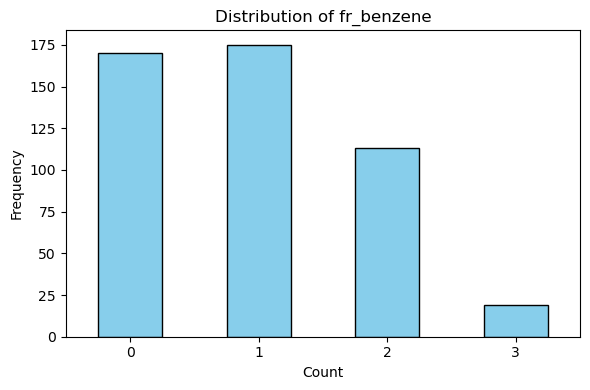

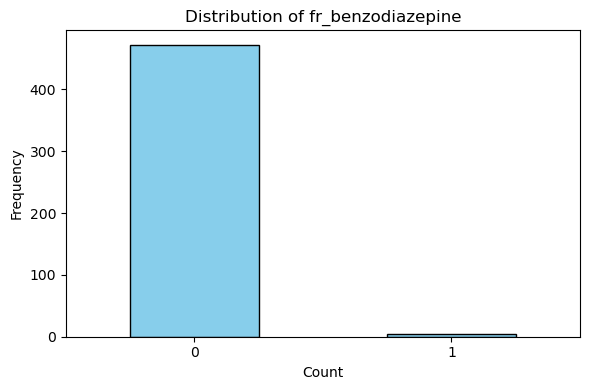

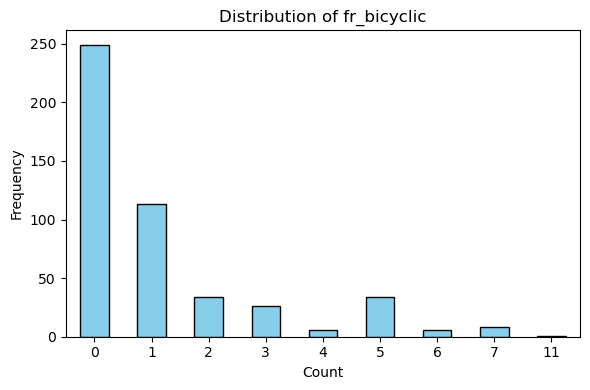

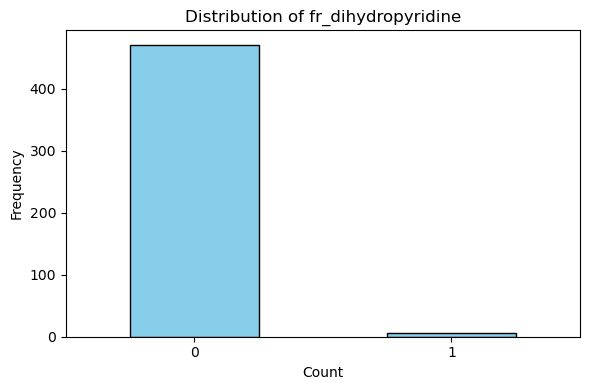

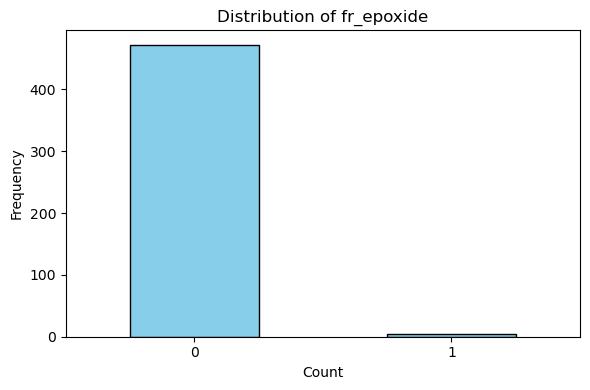

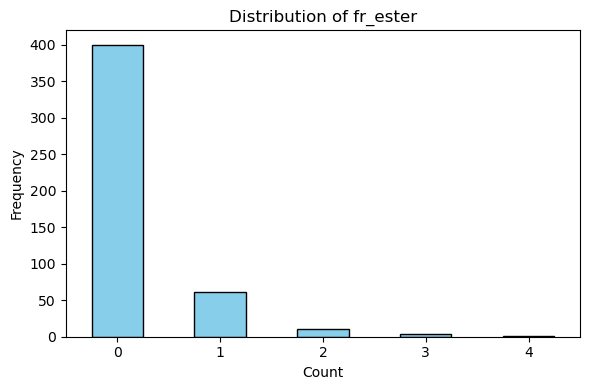

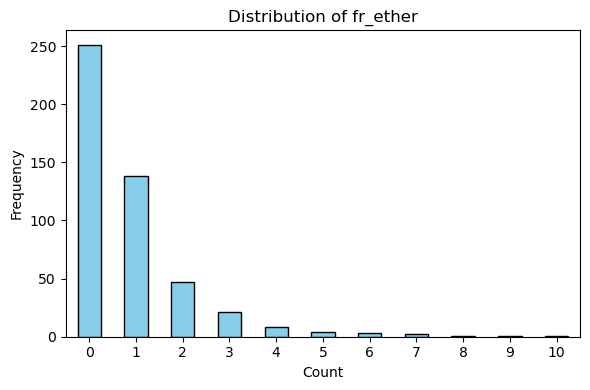

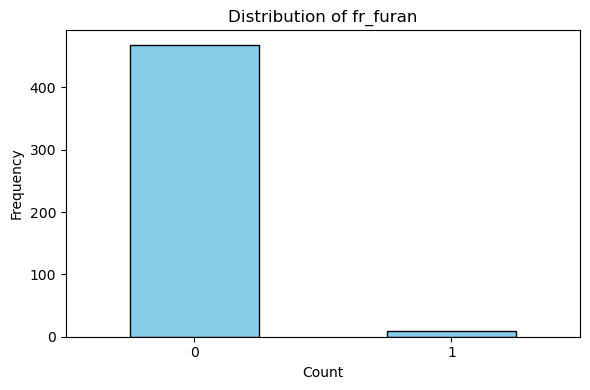

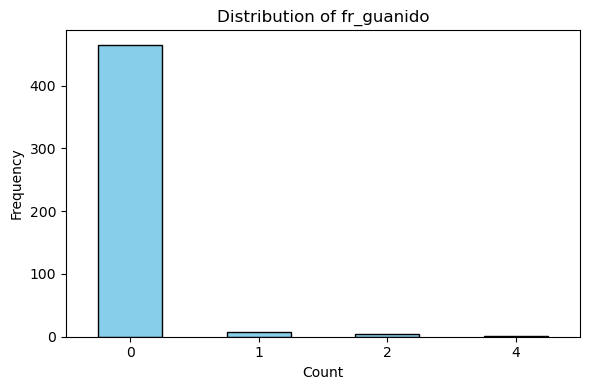

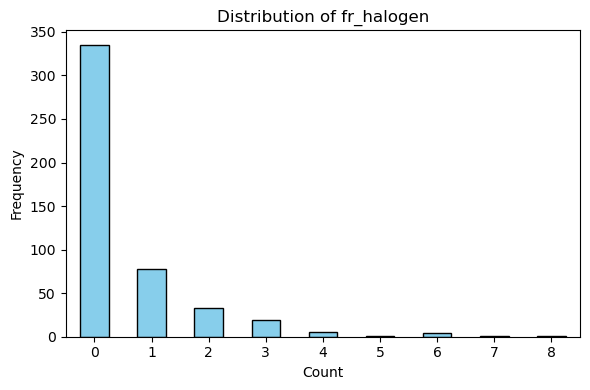

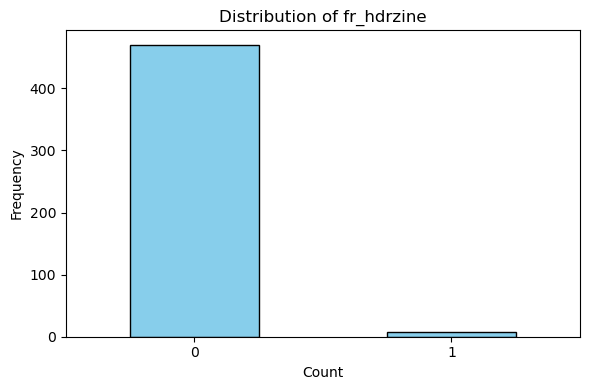

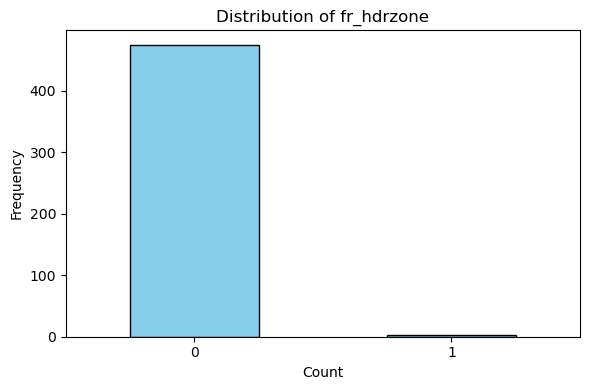

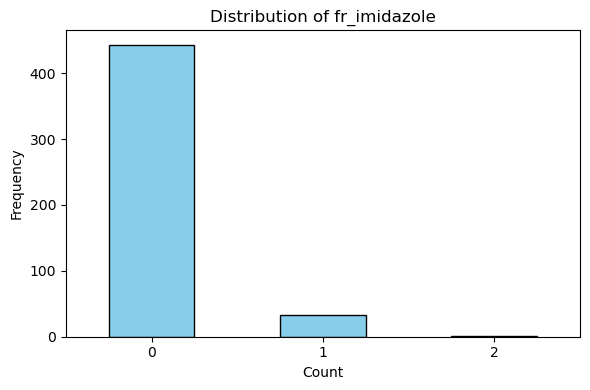

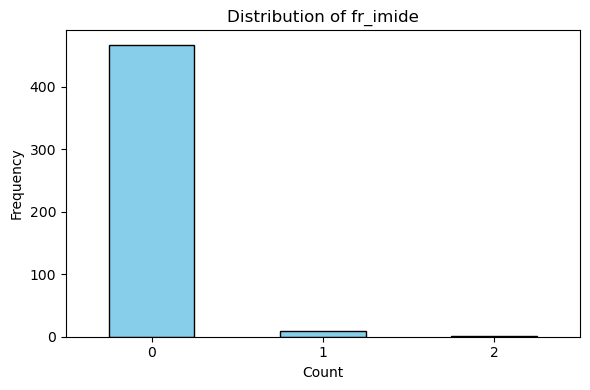

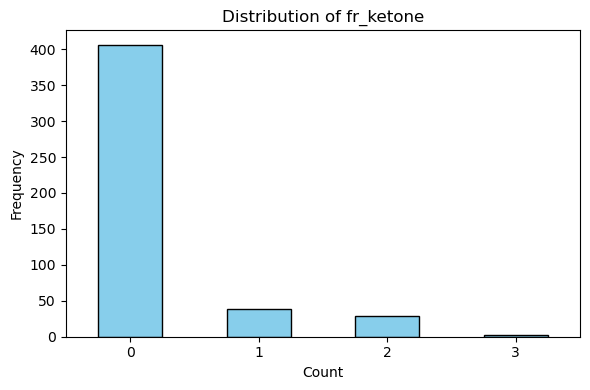

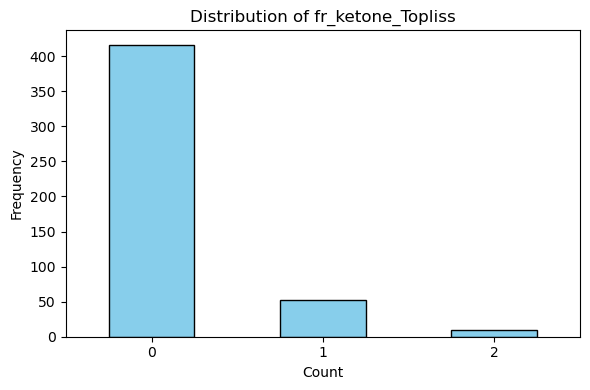

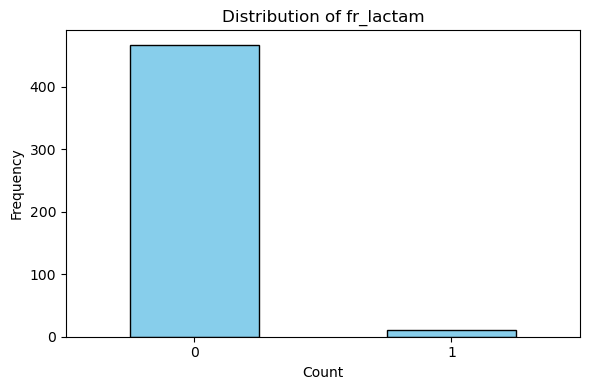

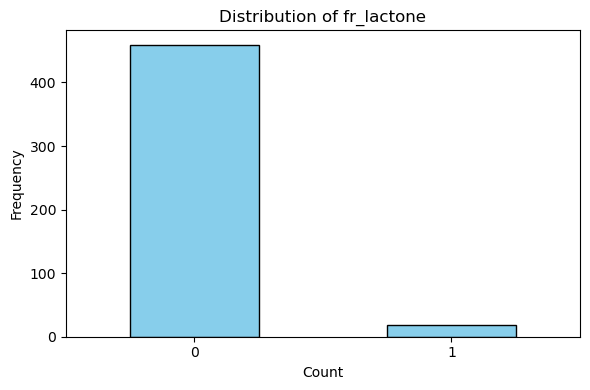

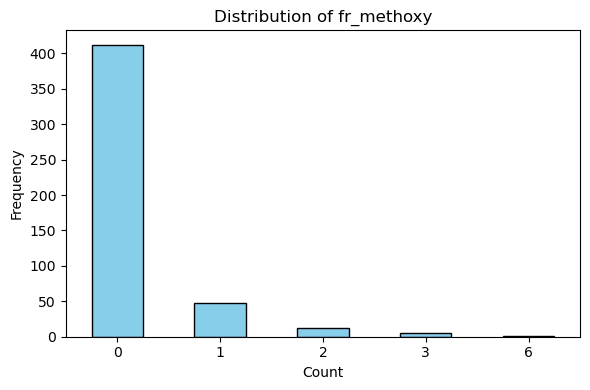

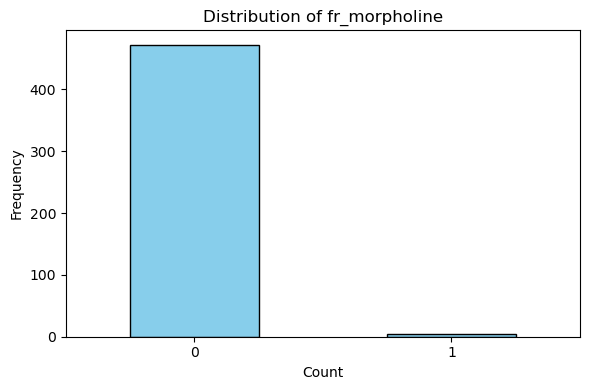

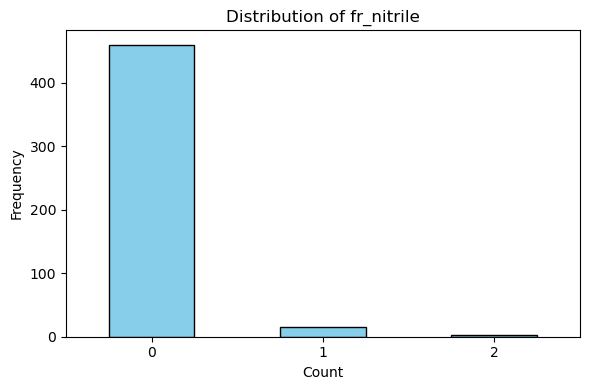

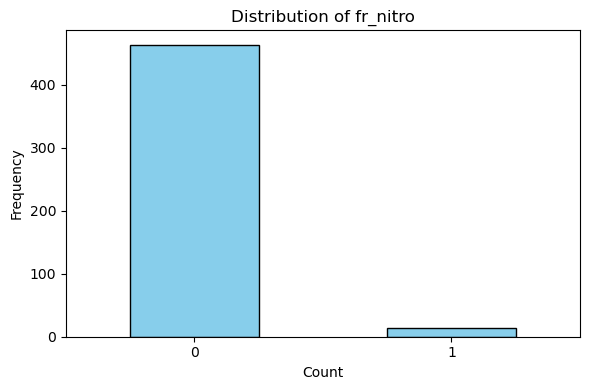

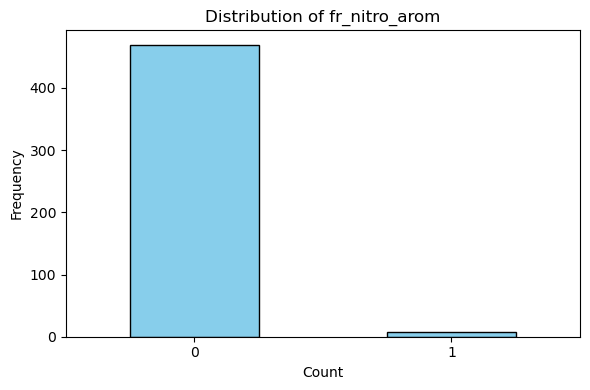

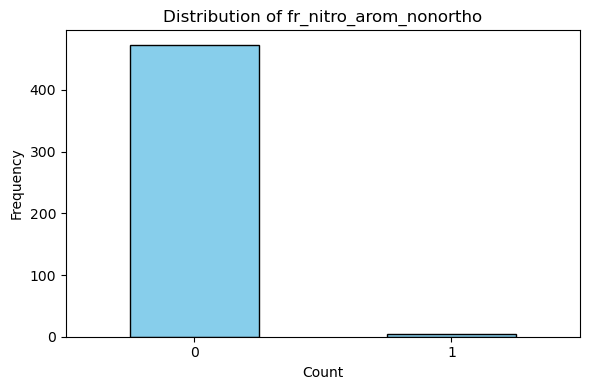

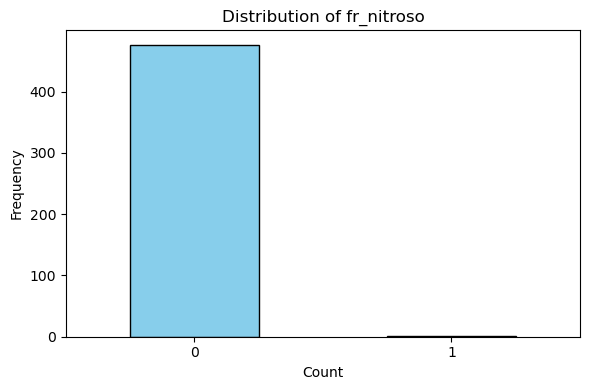

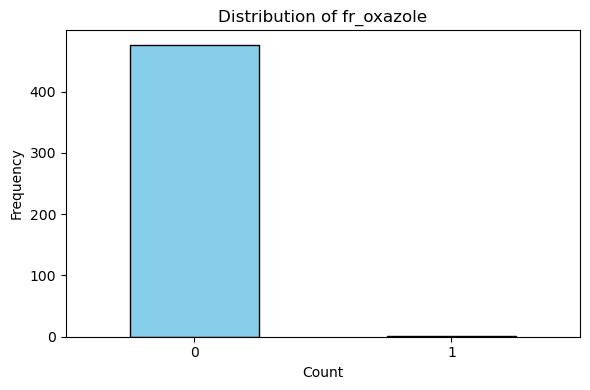

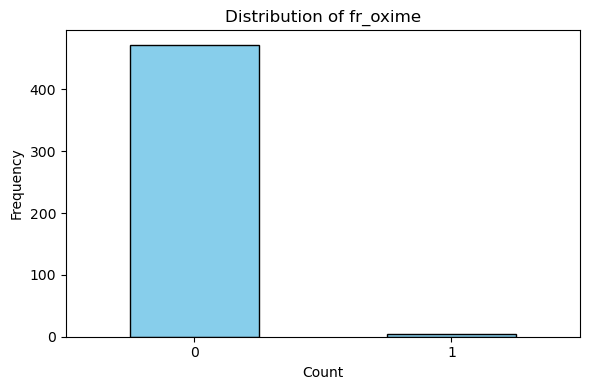

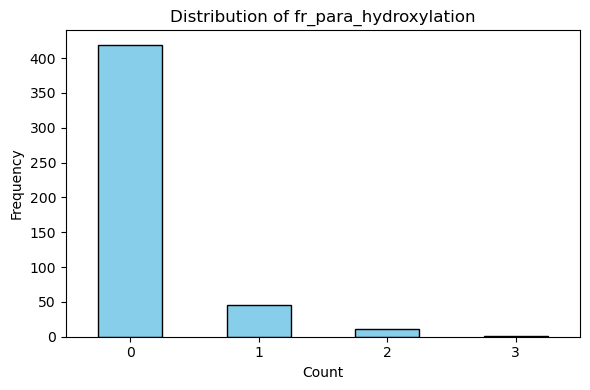

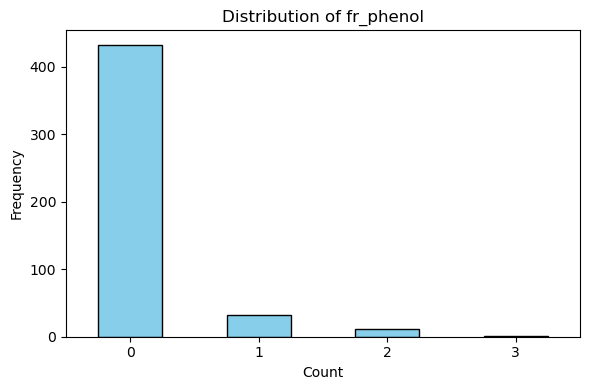

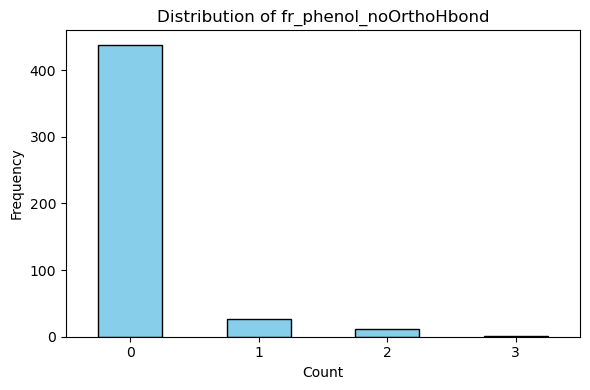

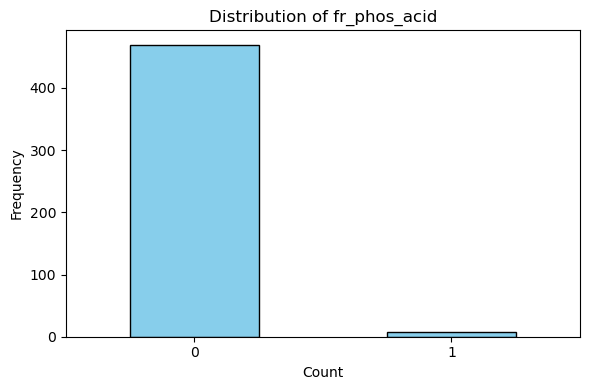

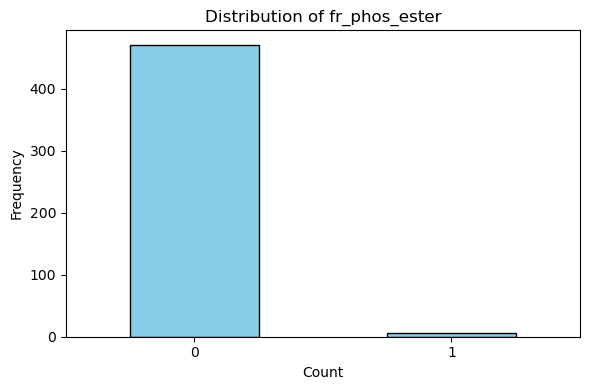

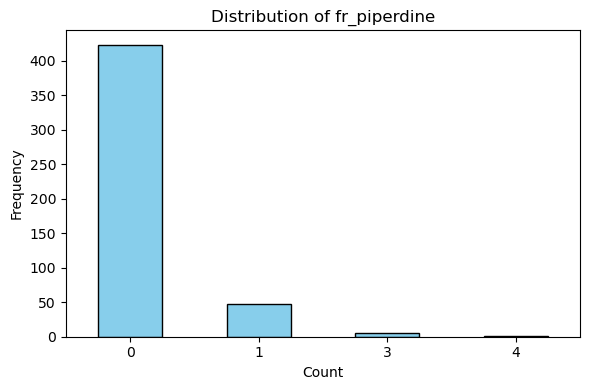

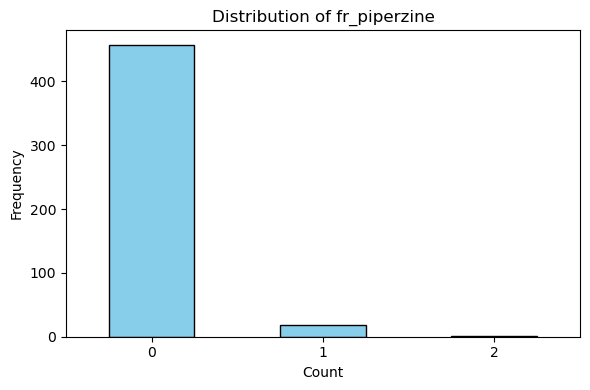

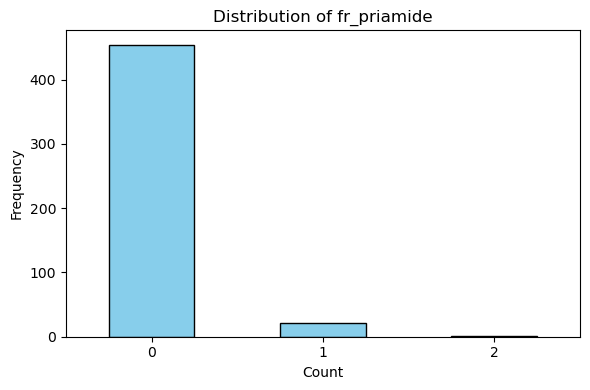

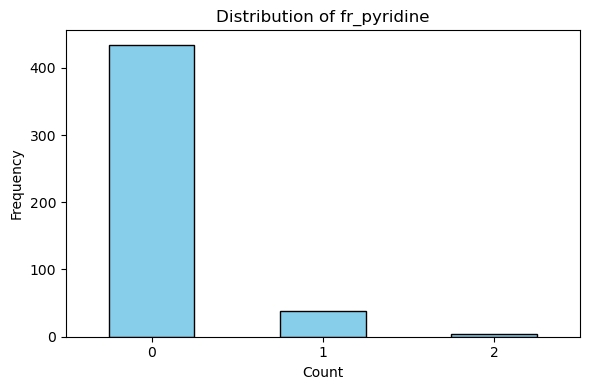

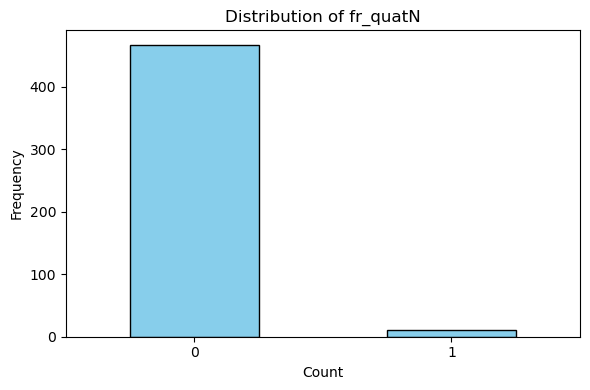

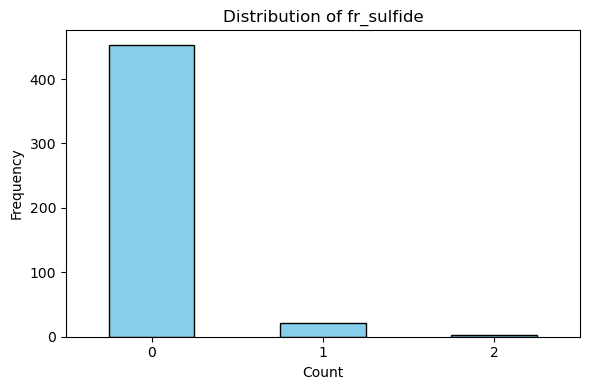

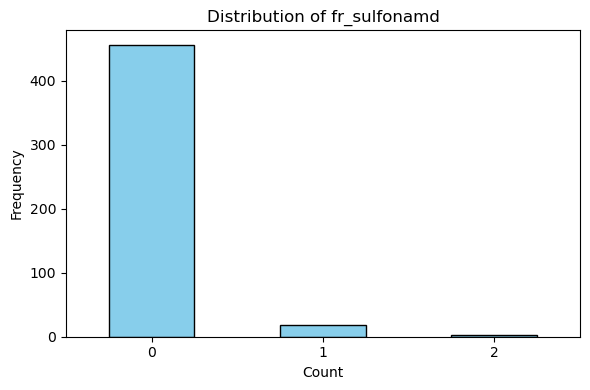

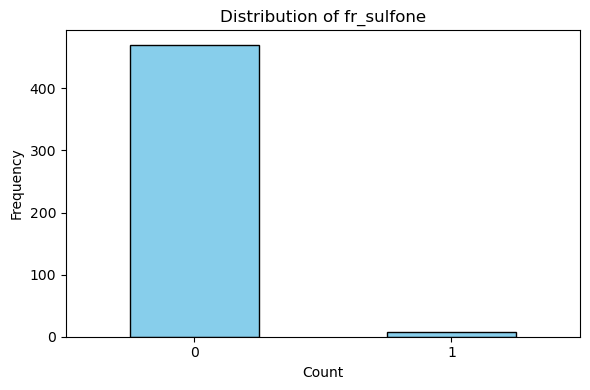

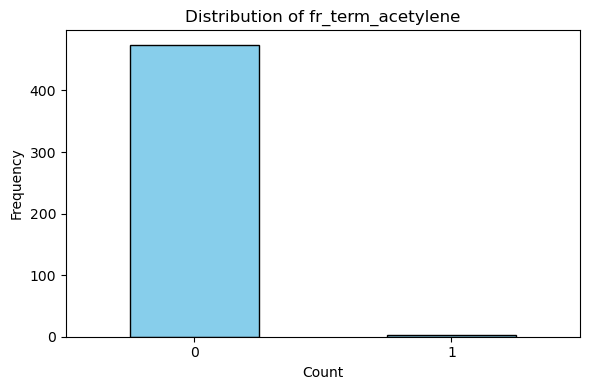

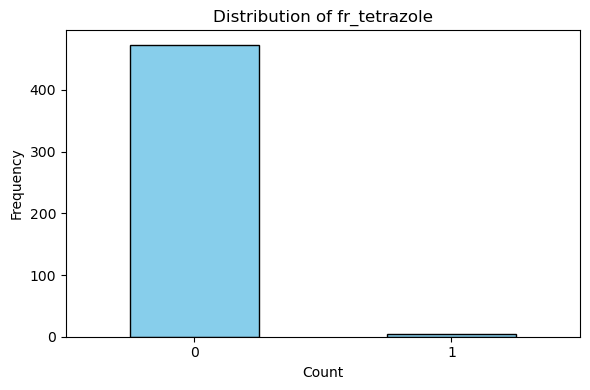

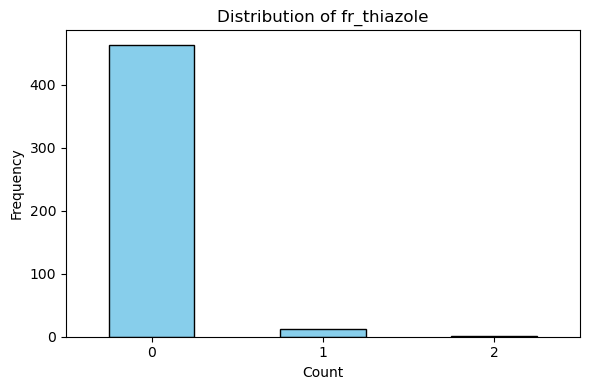

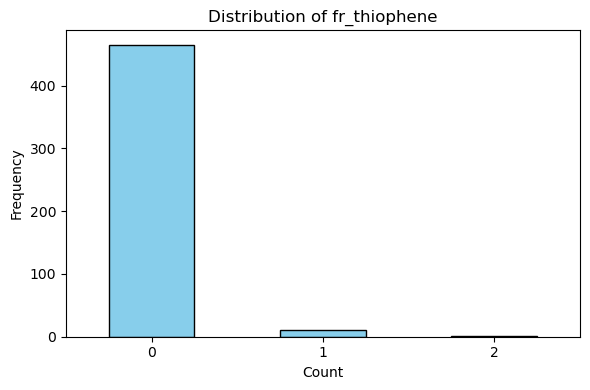

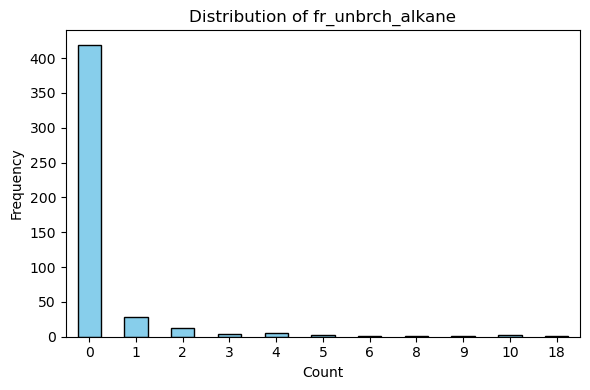

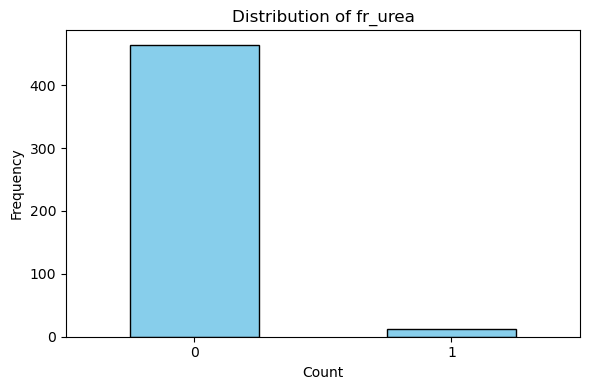

In [19]:
for col in fr_columns:  # num_cols = list of your 'Num' columns
    plt.figure(figsize=(6, 4))
    drug[col].value_counts().sort_index().plot(kind='bar', color='skyblue', edgecolor='black')
    plt.title(f'Distribution of {col}')
    plt.xlabel('Count')
    plt.ylabel('Frequency')
    plt.xticks(rotation=0)
    plt.tight_layout()
    plt.show()

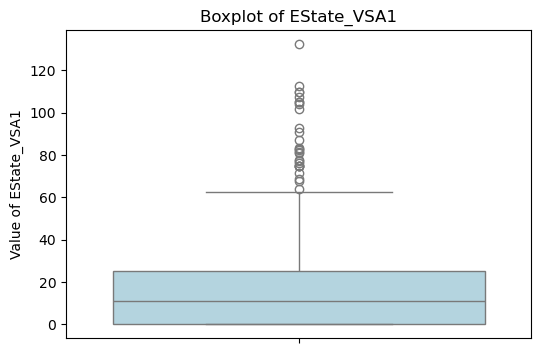

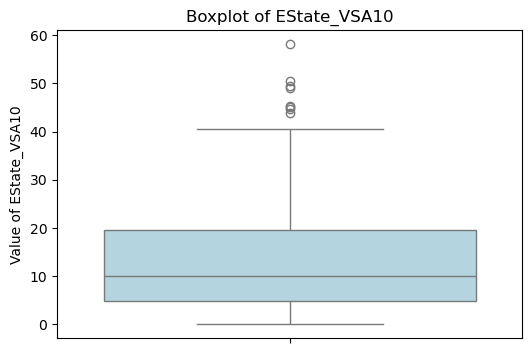

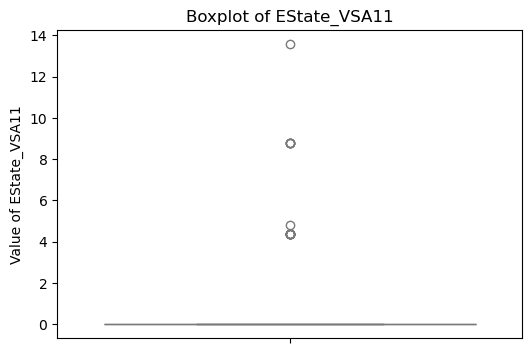

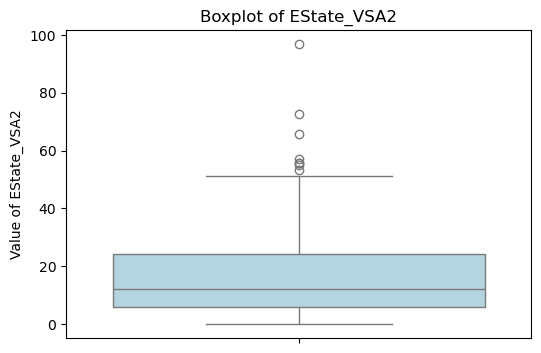

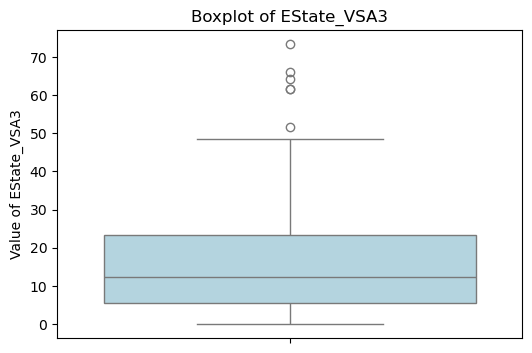

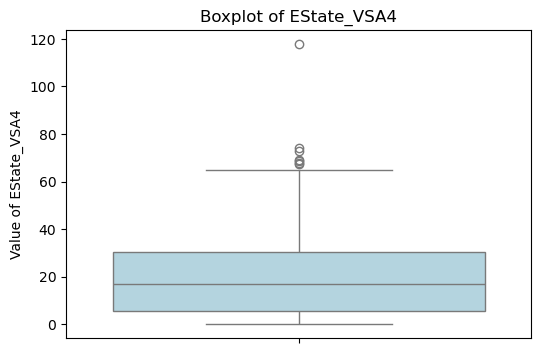

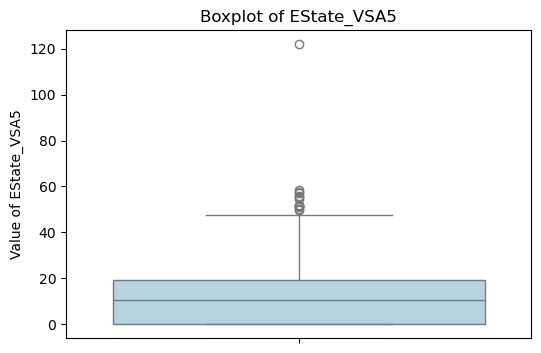

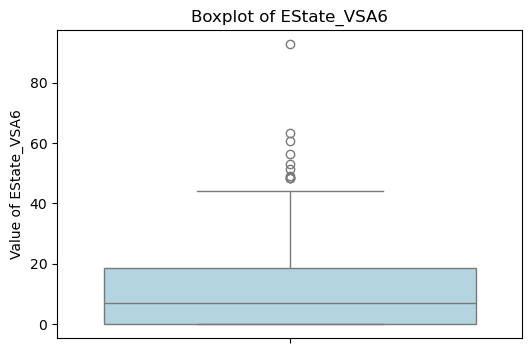

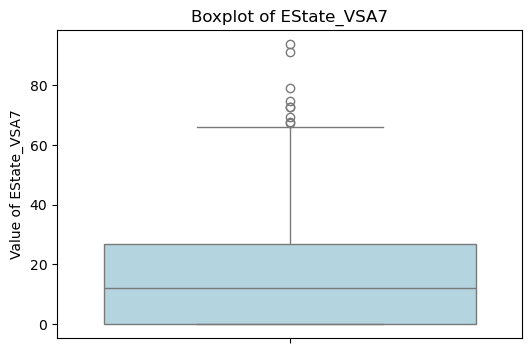

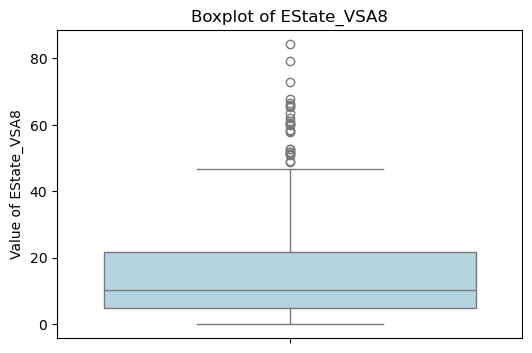

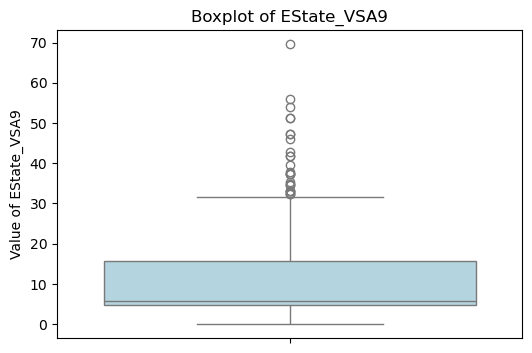

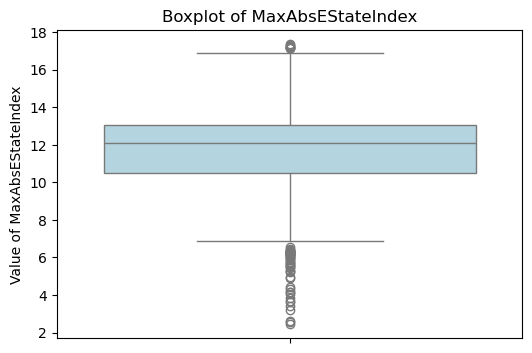

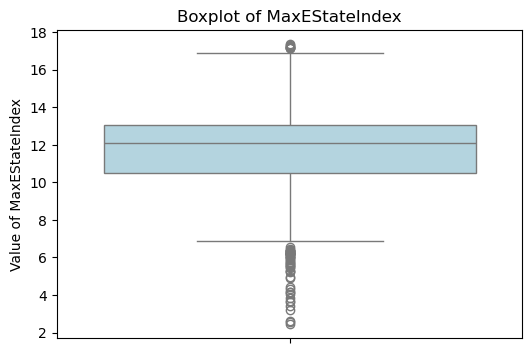

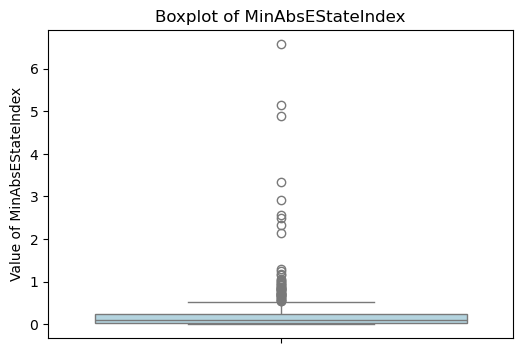

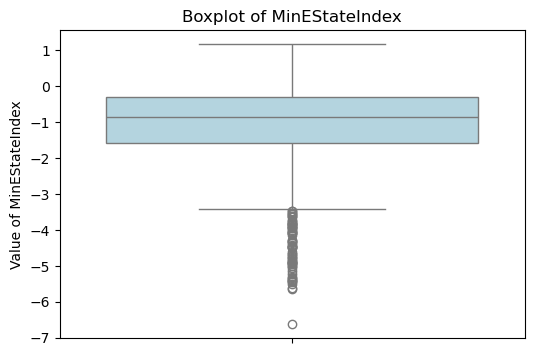

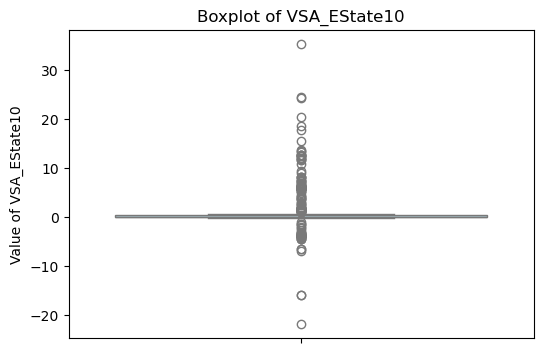

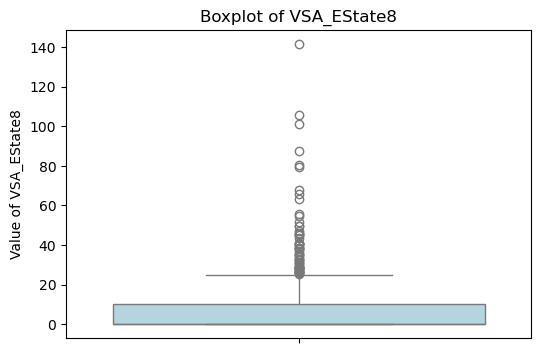

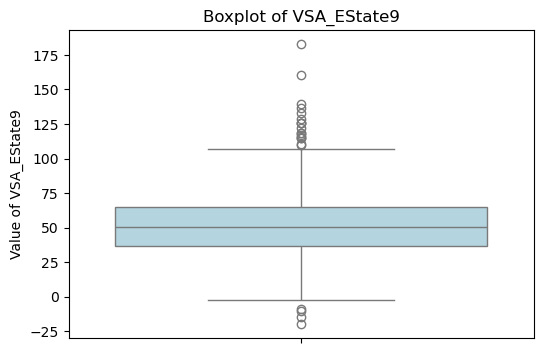

In [20]:
for col in Estate_columns:
    plt.figure(figsize=(6, 4))
    sns.boxplot(y=drug[col], color='lightblue')
    plt.title(f'Boxplot of {col}')
    plt.ylabel(f'Value of {col}')
    plt.show()

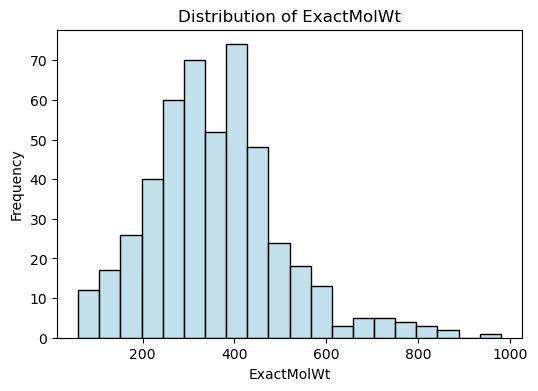

In [21]:
plt.figure(figsize=(6, 4))
sns.histplot(x=drug['ExactMolWt'], bins =20, color='lightblue')
plt.title(f'Distribution of ExactMolWt')
plt.ylabel(f'Frequency')
plt.show()

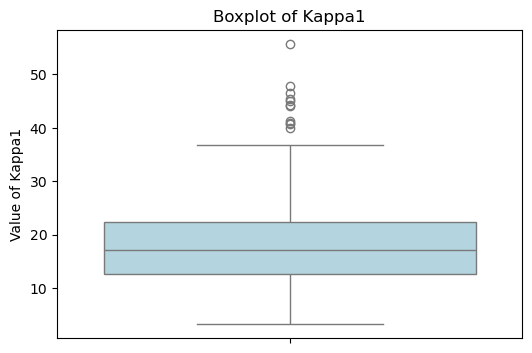

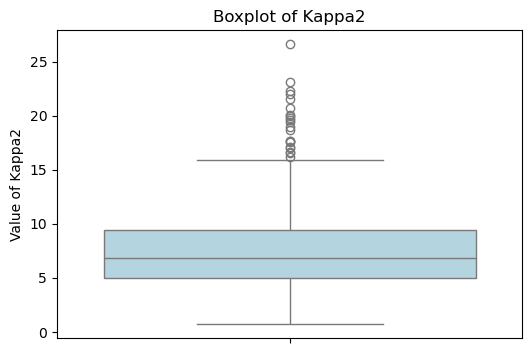

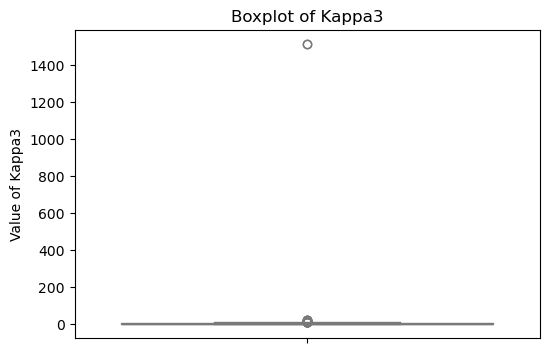

In [22]:
for col in kappa_columns:
    plt.figure(figsize=(6, 4))
    sns.boxplot(y=drug[col], color='lightblue')
    plt.title(f'Boxplot of {col}')
    plt.ylabel(f'Value of {col}')
    plt.show()

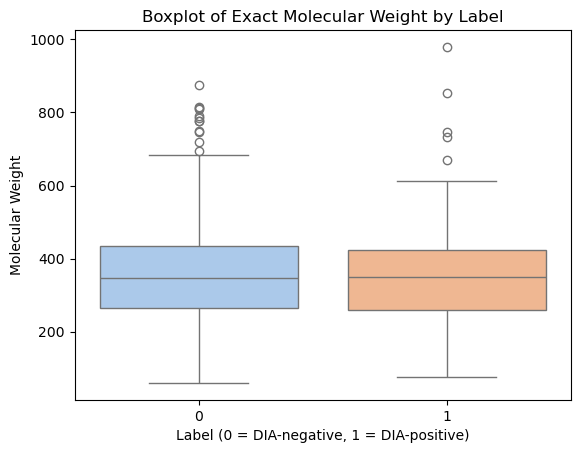

In [23]:
#Hypothesis 1
sns.boxplot(x='Label', y='ExactMolWt', data=drug, palette='pastel')
plt.title('Boxplot of Exact Molecular Weight by Label')
plt.xlabel('Label (0 = DIA-negative, 1 = DIA-positive)')
plt.ylabel('Molecular Weight')
plt.show()

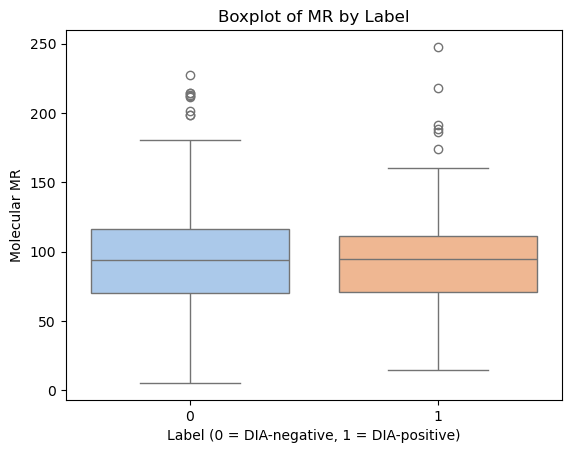

In [24]:
#Hypothesis 2
sns.boxplot(x='Label', y='MolMR', data=drug, palette='pastel')
plt.title('Boxplot of MR by Label')
plt.xlabel('Label (0 = DIA-negative, 1 = DIA-positive)')
plt.ylabel('Molecular MR')
plt.show()

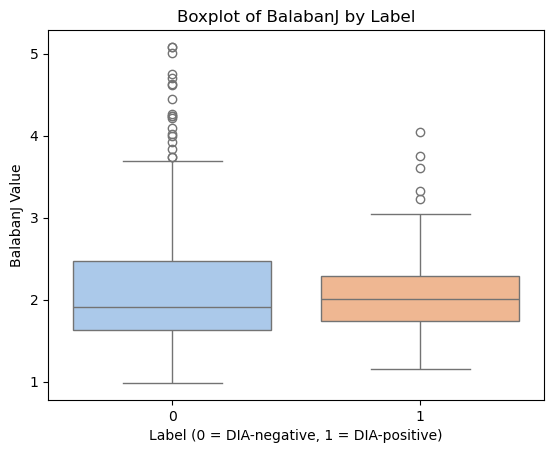

In [25]:
#Hypothesis 3
sns.boxplot(x='Label', y='BalabanJ', data=drug, palette='pastel')
plt.title('Boxplot of BalabanJ by Label')
plt.xlabel('Label (0 = DIA-negative, 1 = DIA-positive)')
plt.ylabel('BalabanJ Value')
plt.show()

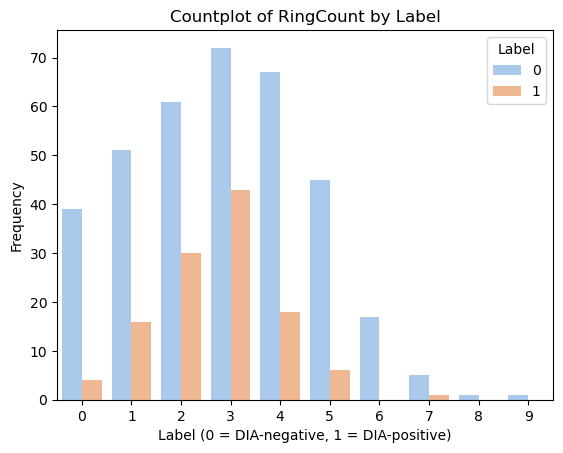

In [26]:
#Hypothesis 4
sns.countplot(x='RingCount', hue = 'Label', data=drug, palette='pastel')
plt.title('Countplot of RingCount by Label')
plt.xlabel('Label (0 = DIA-negative, 1 = DIA-positive)')
plt.ylabel('Frequency')
plt.show()

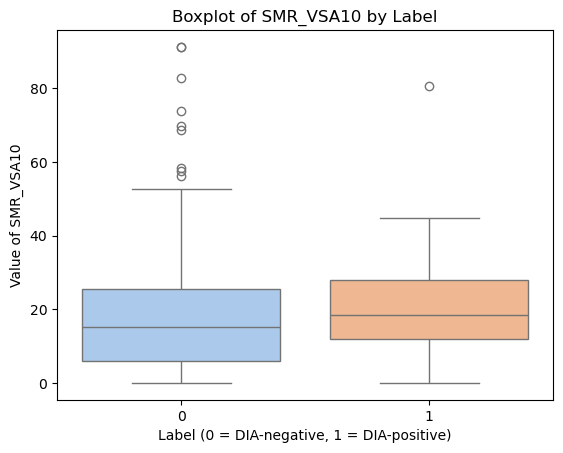

In [27]:
#Hypothesis 5
sns.boxplot(x='Label', y='SMR_VSA10', data=drug, palette='pastel')
plt.title('Boxplot of SMR_VSA10 by Label')
plt.xlabel('Label (0 = DIA-negative, 1 = DIA-positive)')
plt.ylabel('Value of SMR_VSA10')
plt.show()

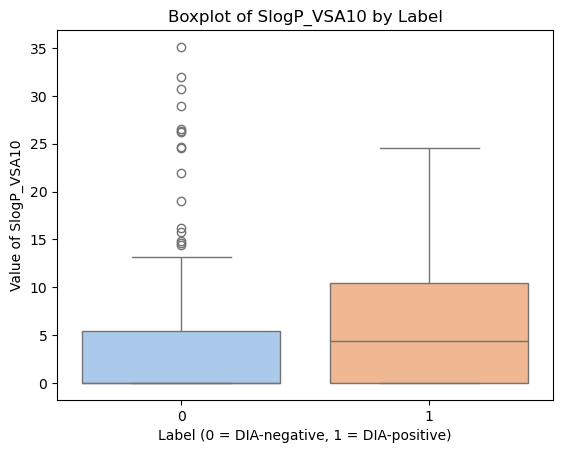

In [28]:
#Hypothesis 6
sns.boxplot(x='Label', y='SlogP_VSA10', data=drug, palette='pastel')
plt.title('Boxplot of SlogP_VSA10 by Label')
plt.xlabel('Label (0 = DIA-negative, 1 = DIA-positive)')
plt.ylabel('Value of SlogP_VSA10')
plt.show()

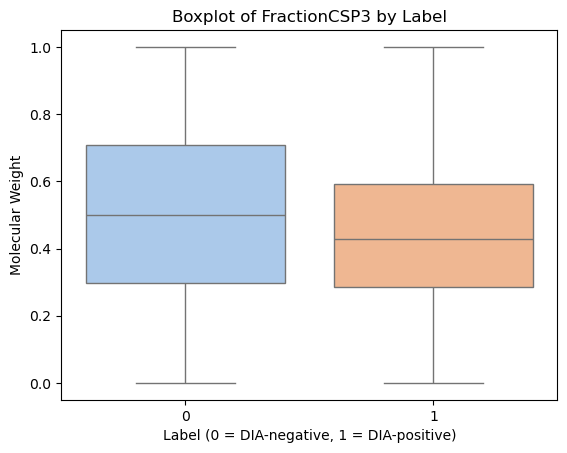

In [29]:
#Hypothesis 7
sns.boxplot(x='Label', y='FractionCSP3', data=drug, palette='pastel')
plt.title('Boxplot of FractionCSP3 by Label')
plt.xlabel('Label (0 = DIA-negative, 1 = DIA-positive)')
plt.ylabel('Molecular Weight')
plt.show()

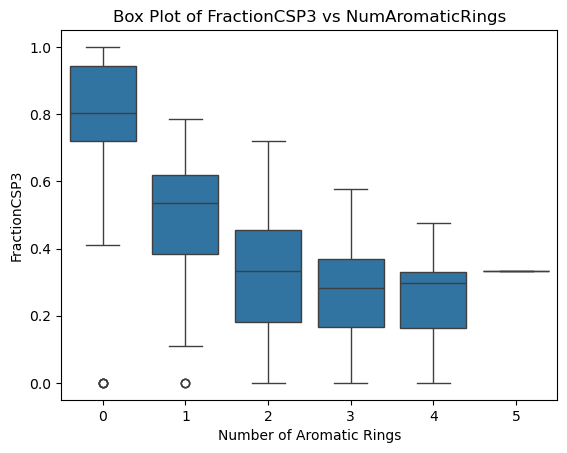

In [30]:
#Hypothesis 8
sns.boxplot(data=drug, x='NumAromaticRings', y='FractionCSP3')
plt.title('Box Plot of FractionCSP3 vs NumAromaticRings')
plt.xlabel('Number of Aromatic Rings')
plt.ylabel('FractionCSP3')
plt.show()

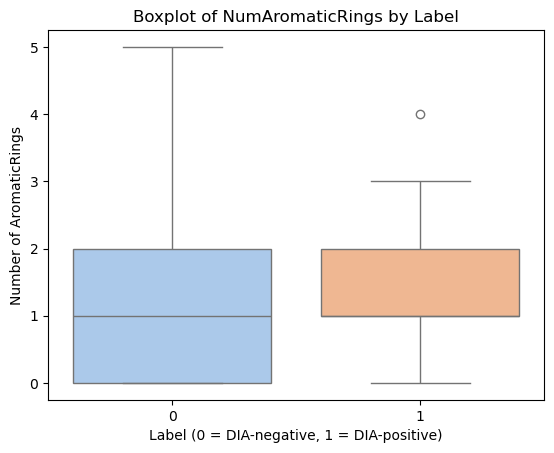

In [31]:
#Hypothesis 9
sns.boxplot(x='Label', y='NumAromaticRings', data=drug, palette='pastel')
plt.title('Boxplot of NumAromaticRings by Label')
plt.xlabel('Label (0 = DIA-negative, 1 = DIA-positive)')
plt.ylabel('Number of AromaticRings')
plt.show()

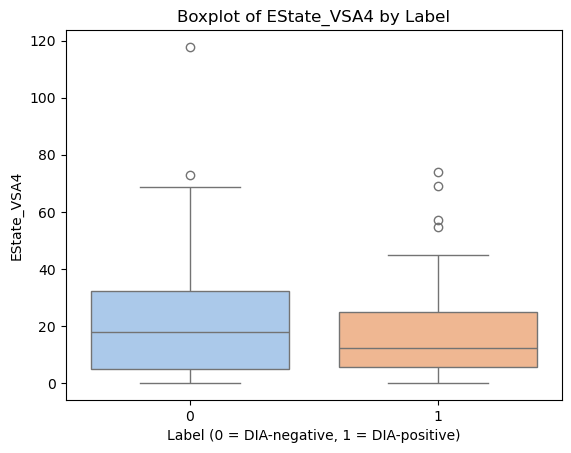

In [32]:
#Hypothesis 10
sns.boxplot(x='Label', y='EState_VSA4', data=drug, palette='pastel')
plt.title('Boxplot of EState_VSA4 by Label')
plt.xlabel('Label (0 = DIA-negative, 1 = DIA-positive)')
plt.ylabel('EState_VSA4')
plt.show()

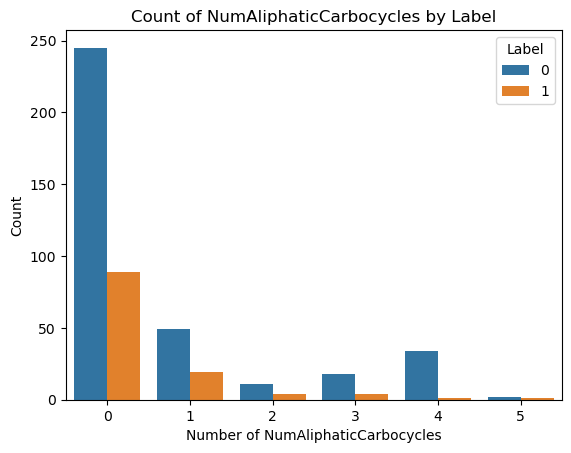

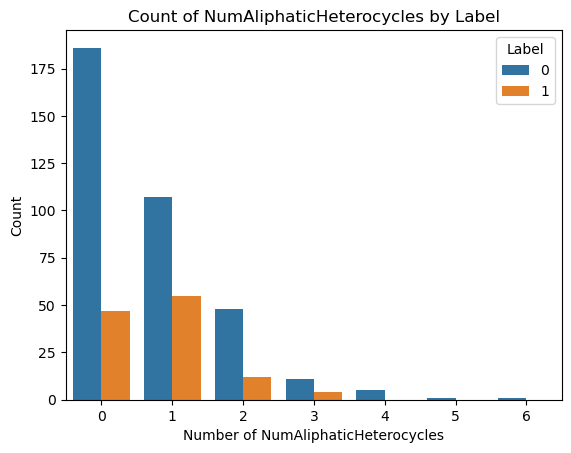

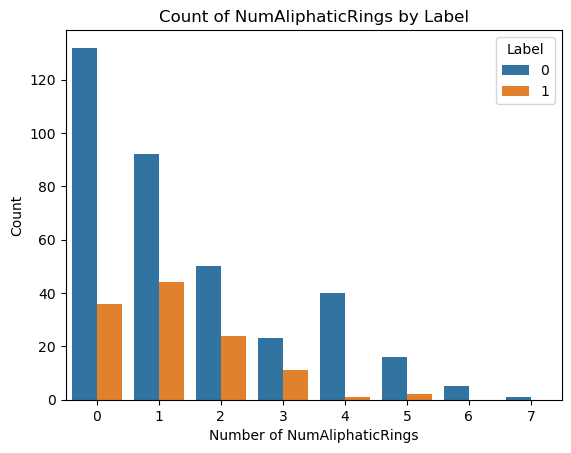

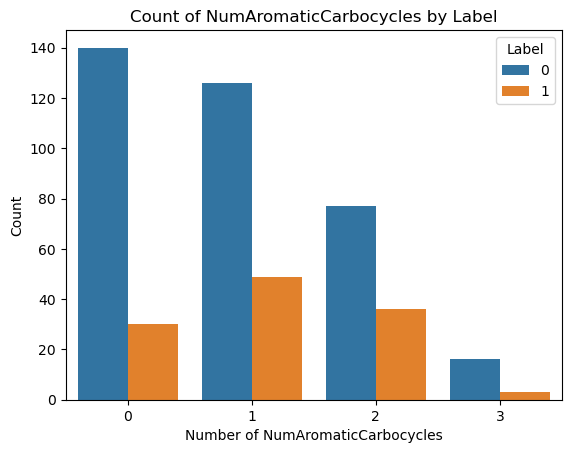

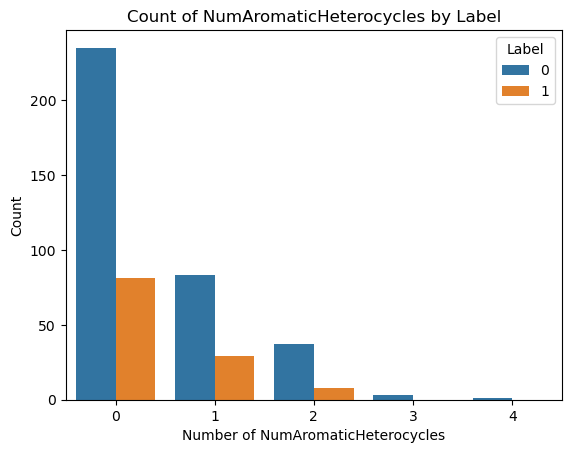

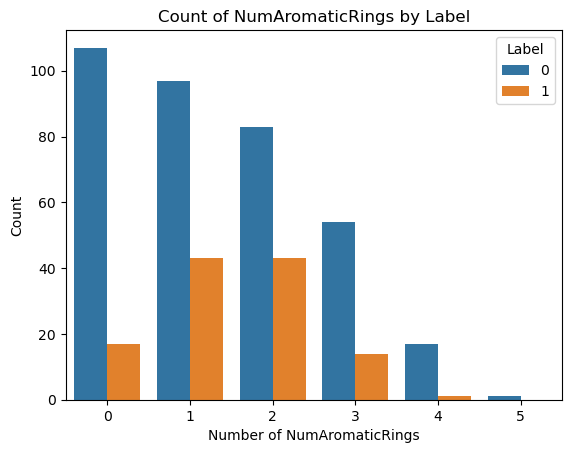

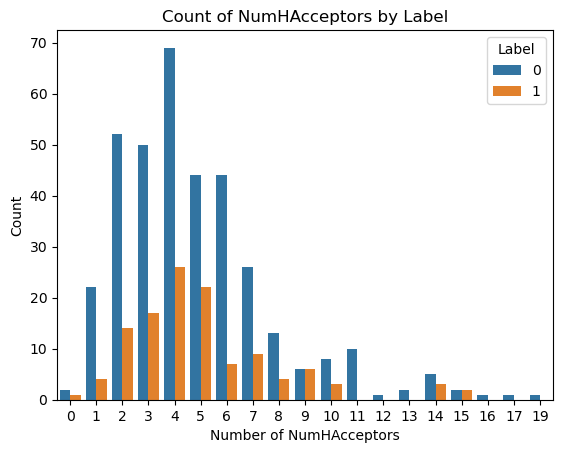

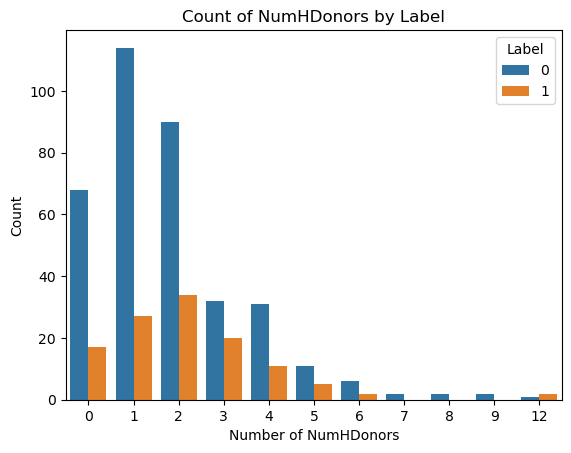

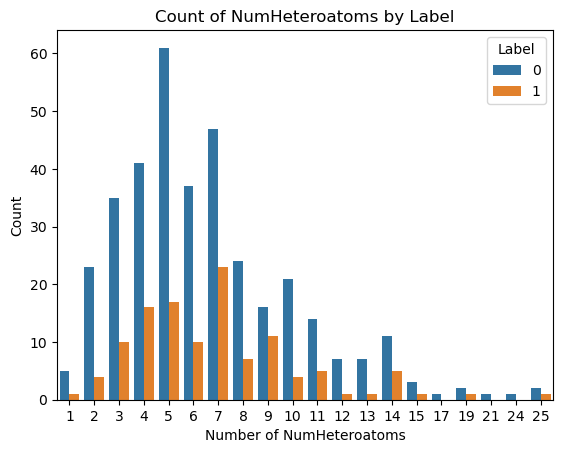

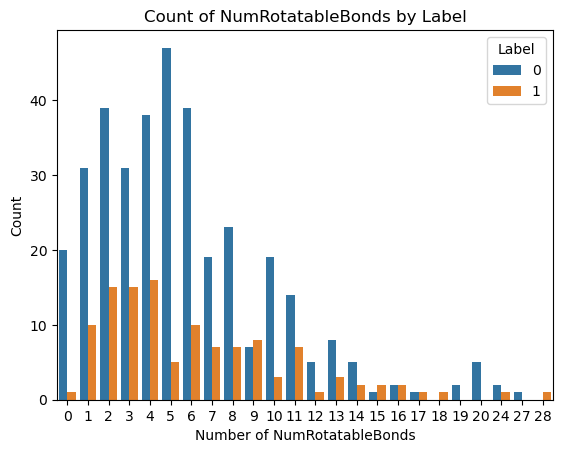

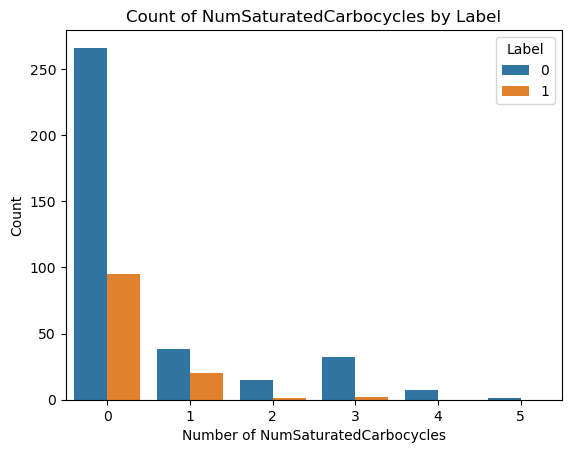

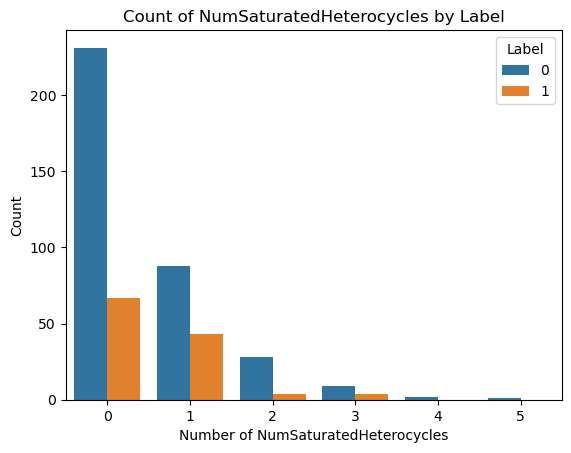

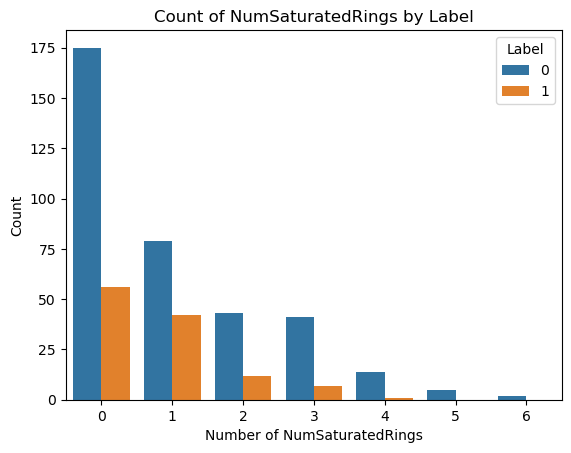

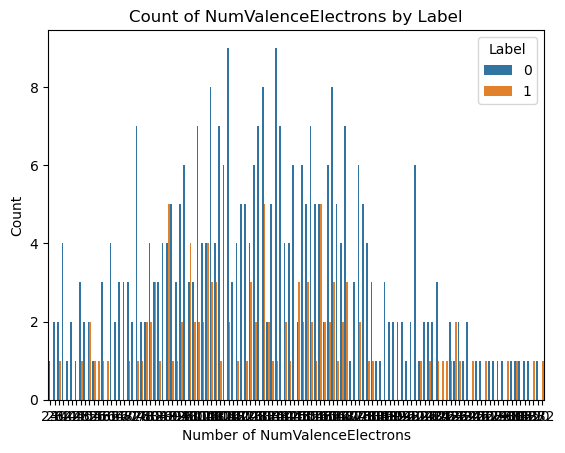

In [33]:
for col in NUM_columns:
    sns.countplot(x=col, hue='Label', data=drug)
    plt.title(f'Count of {col} by Label')
    plt.xlabel(f'Number of {col}')
    plt.ylabel('Count')
    plt.legend(title='Label')
    plt.show()

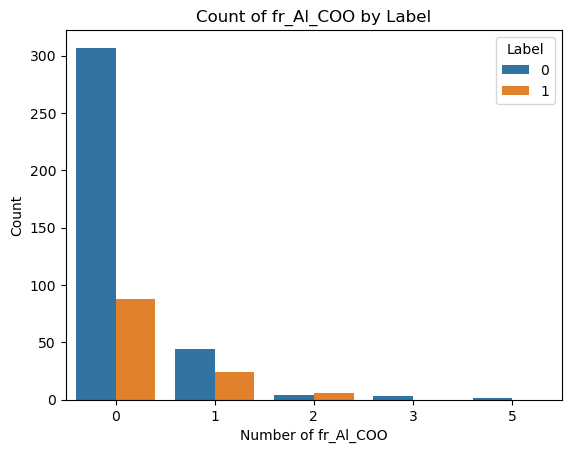

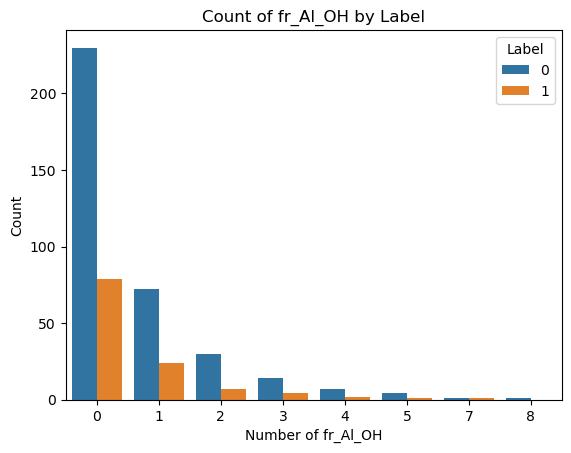

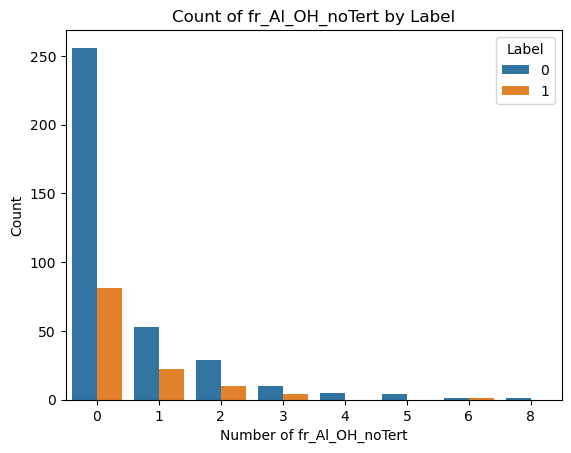

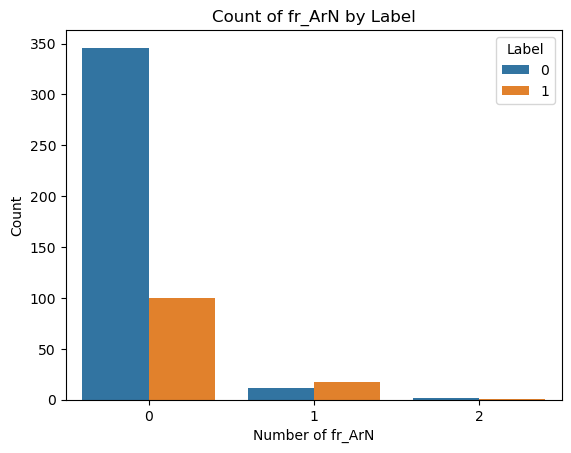

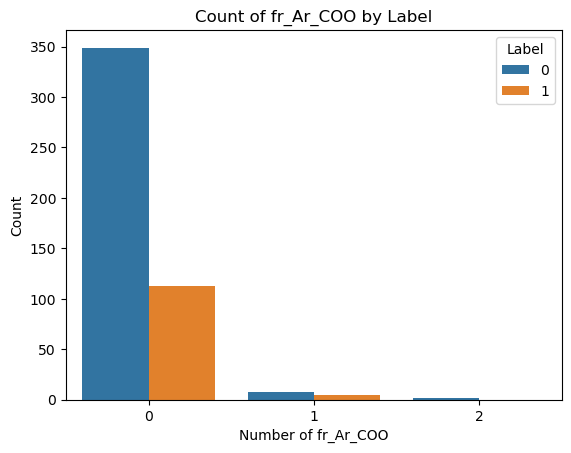

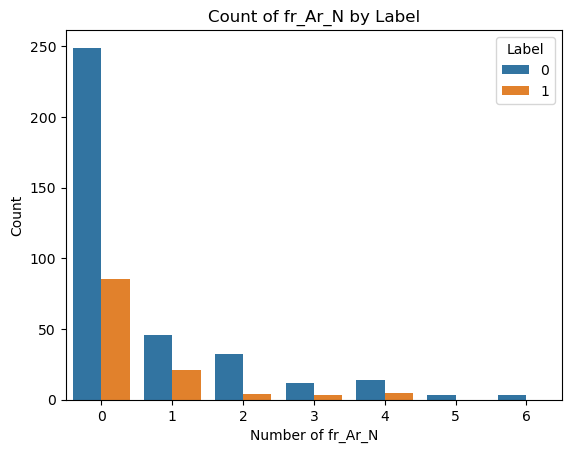

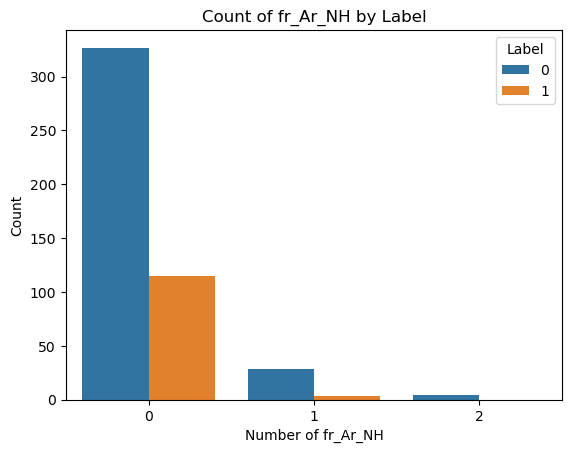

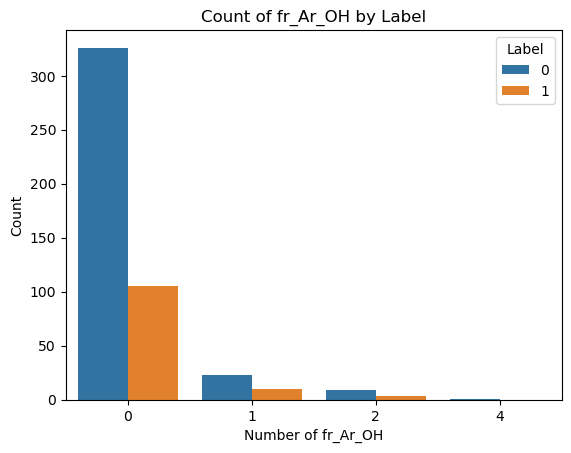

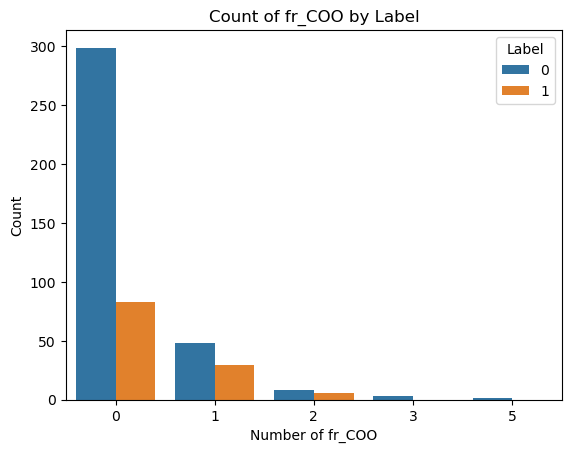

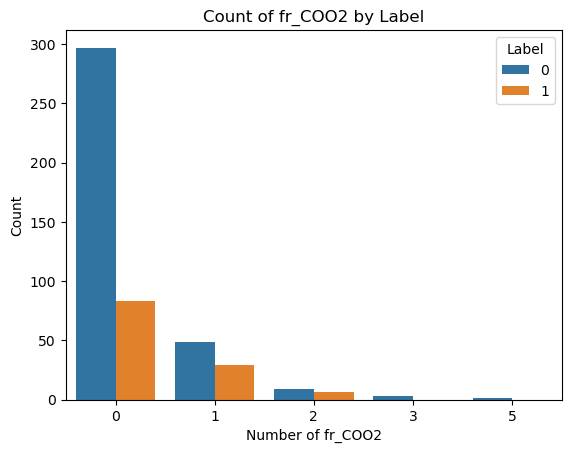

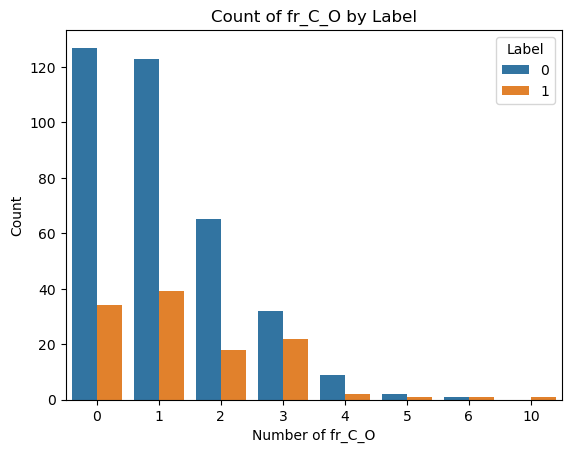

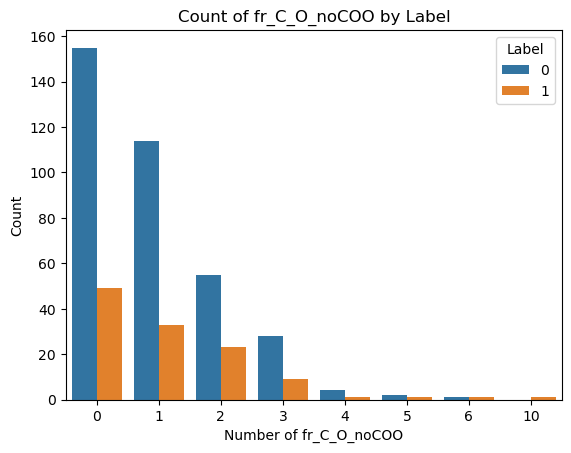

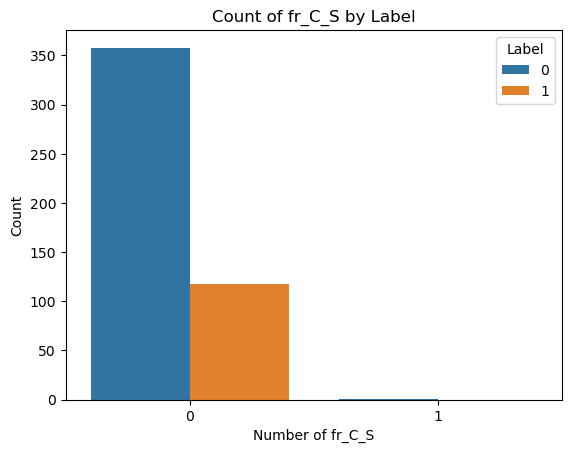

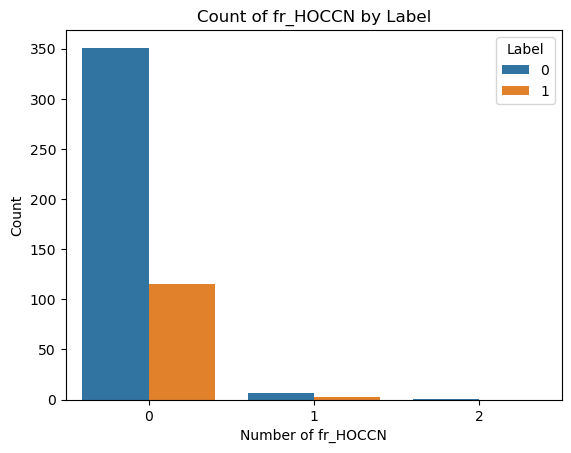

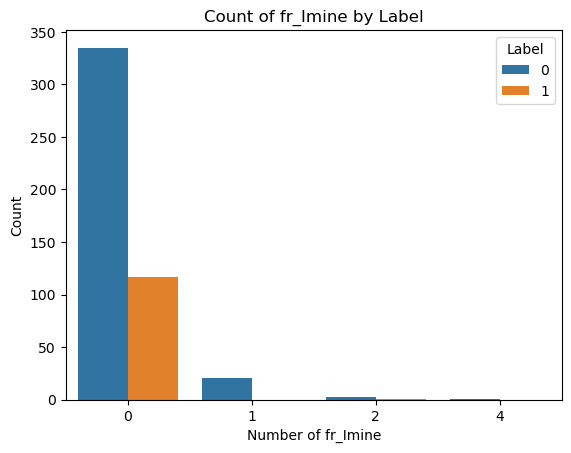

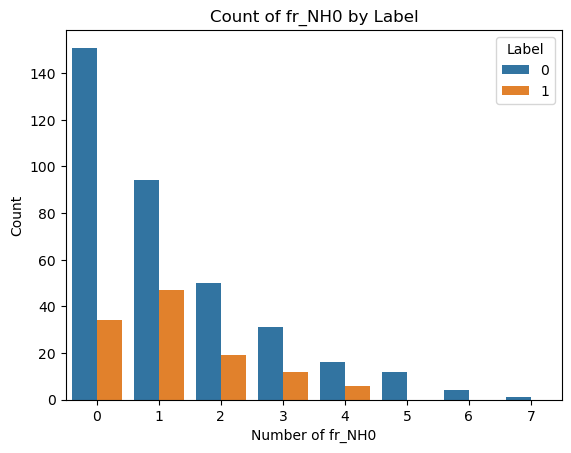

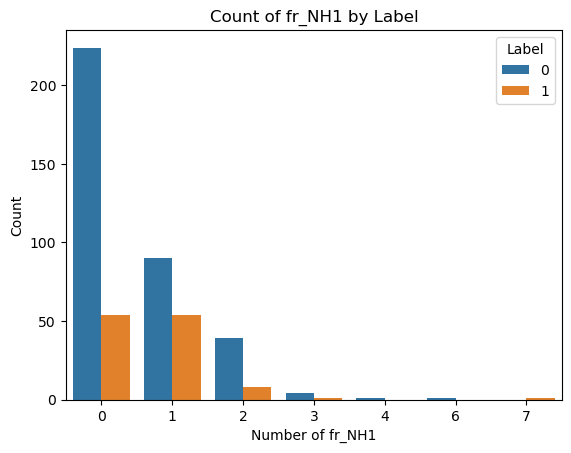

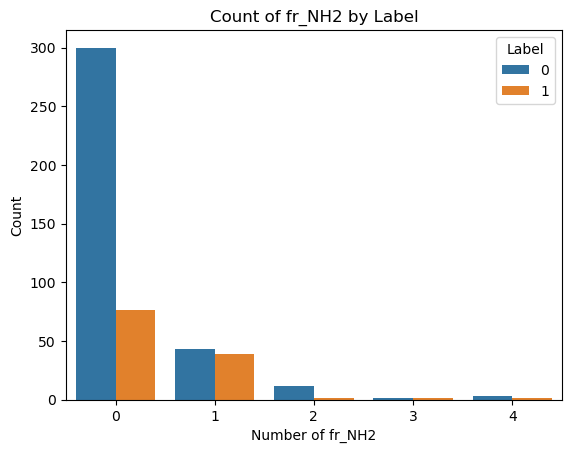

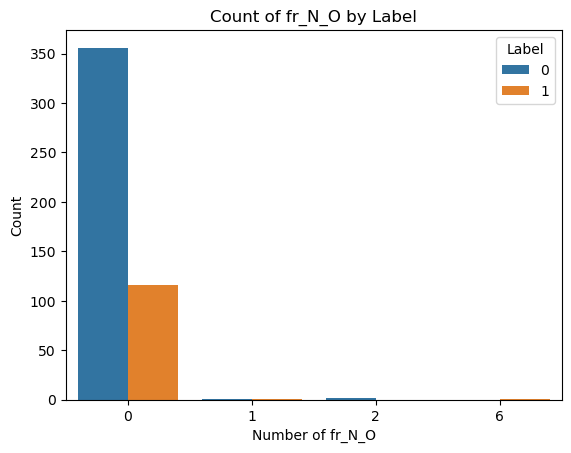

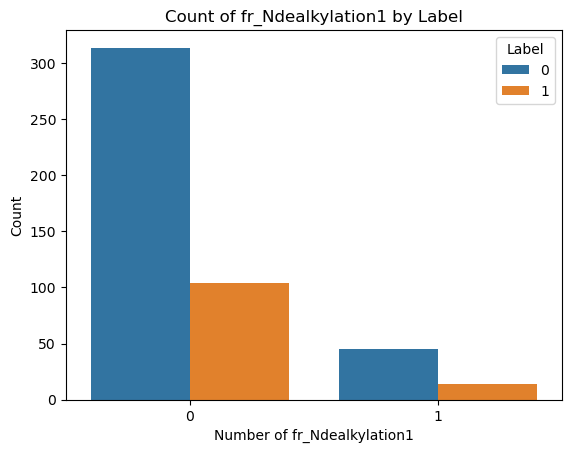

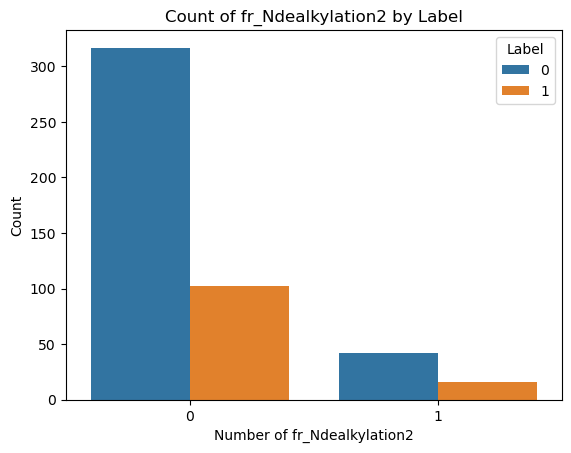

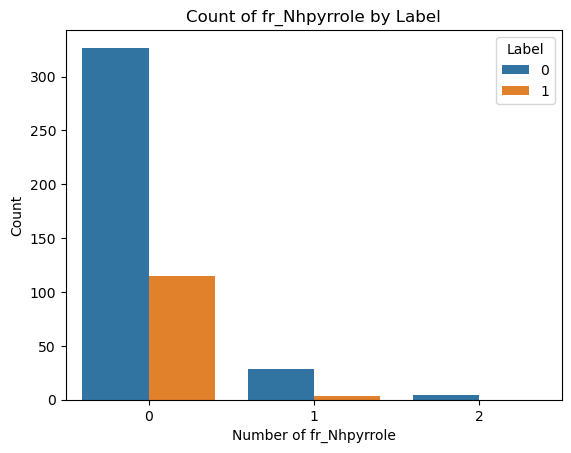

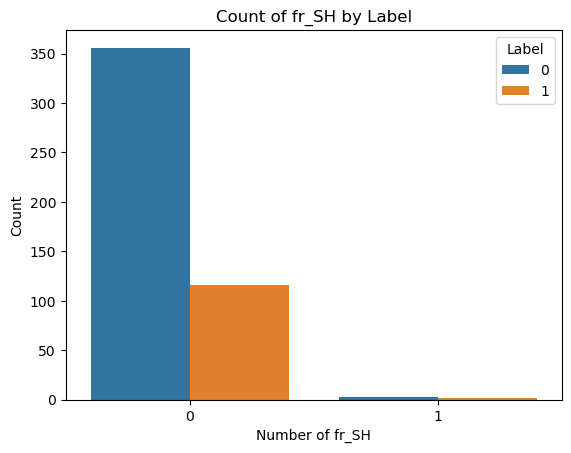

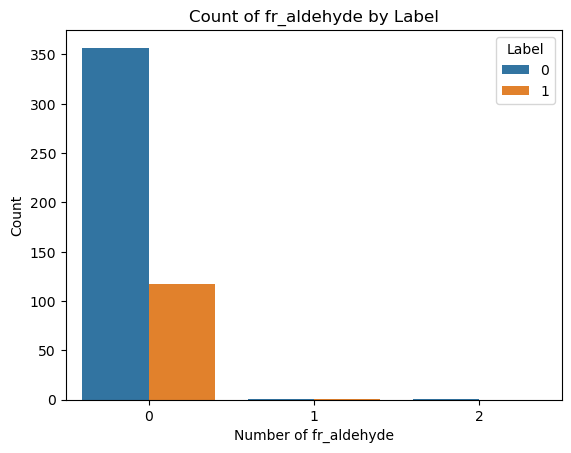

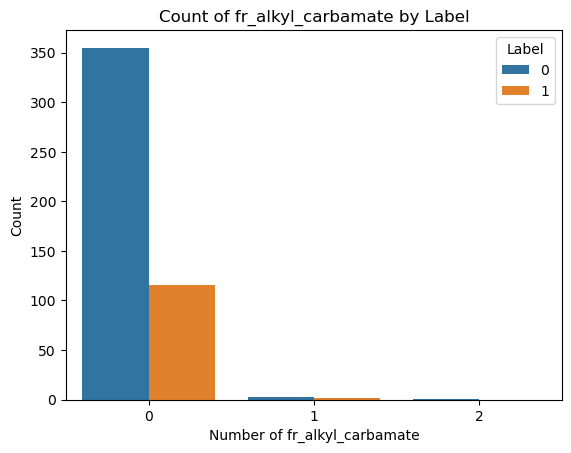

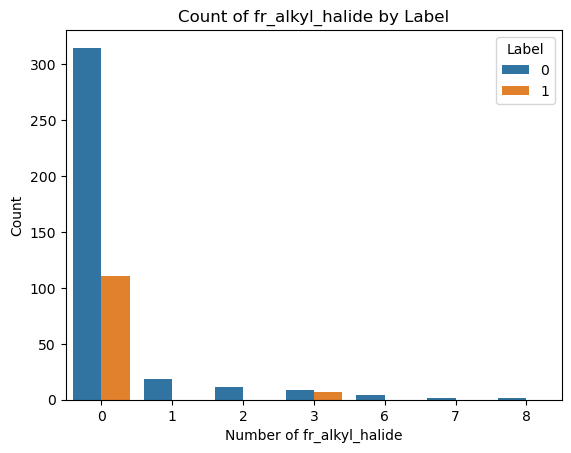

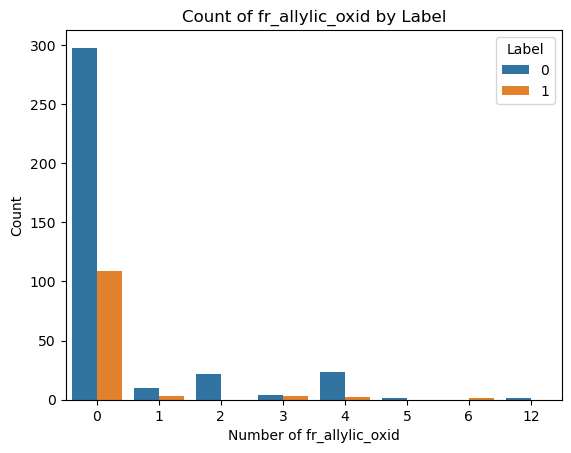

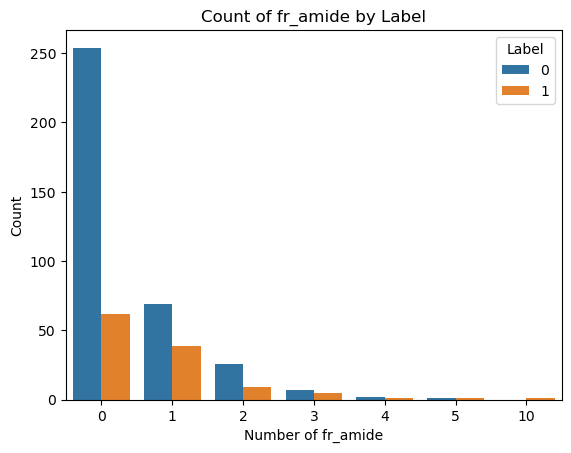

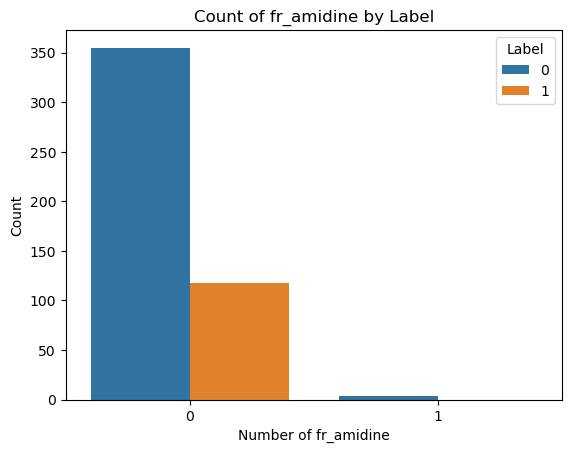

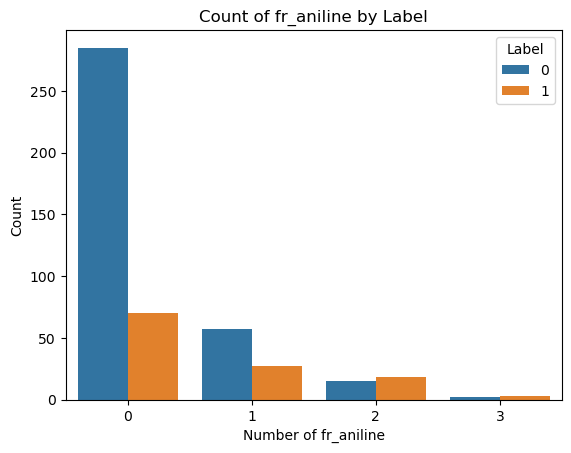

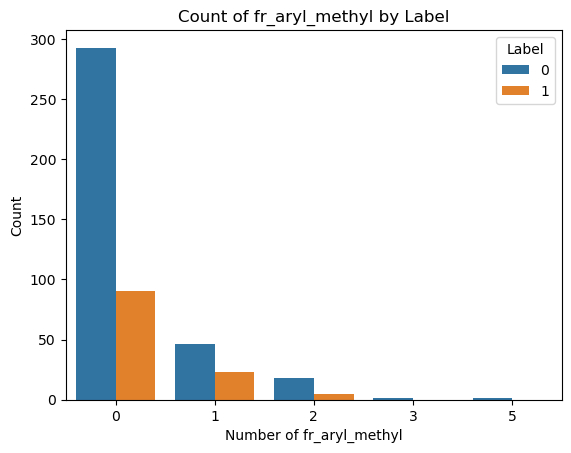

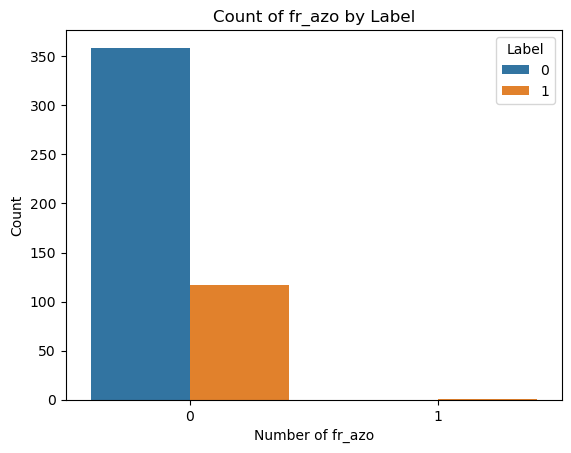

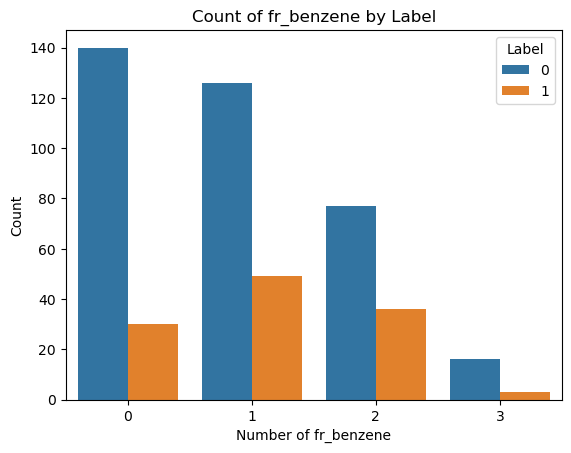

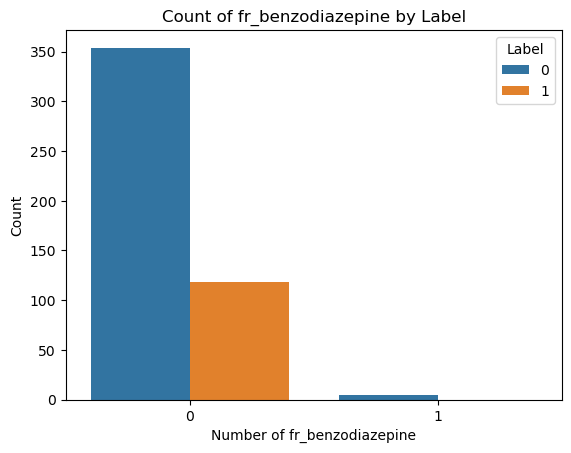

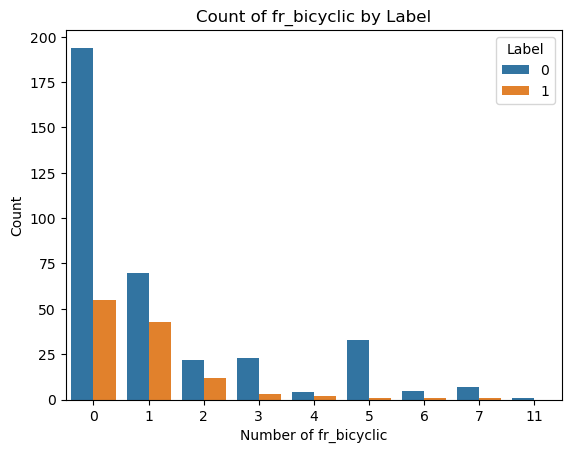

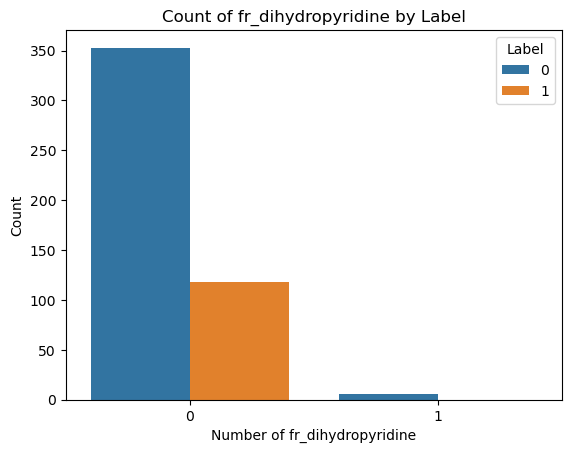

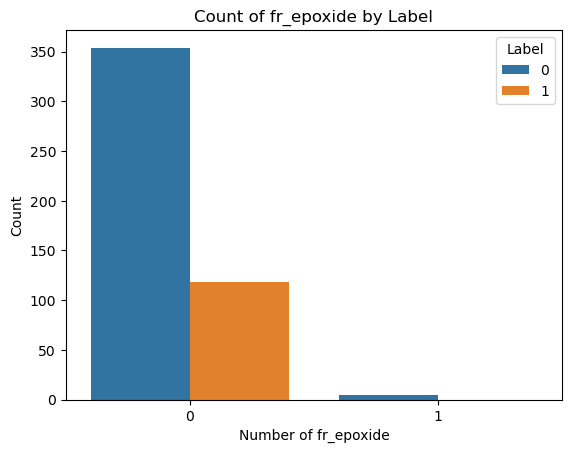

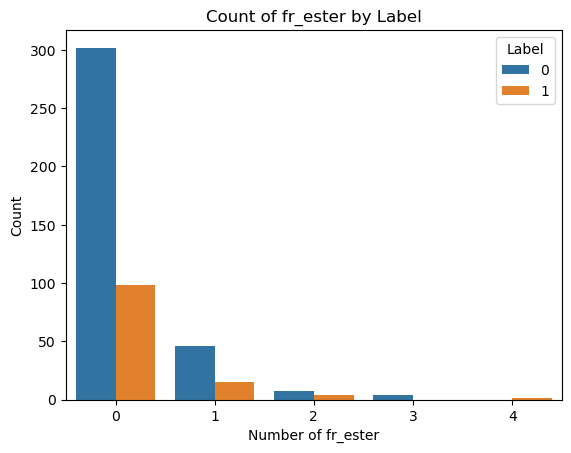

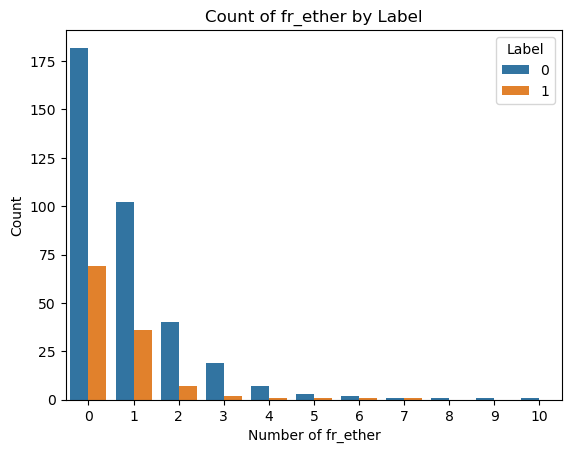

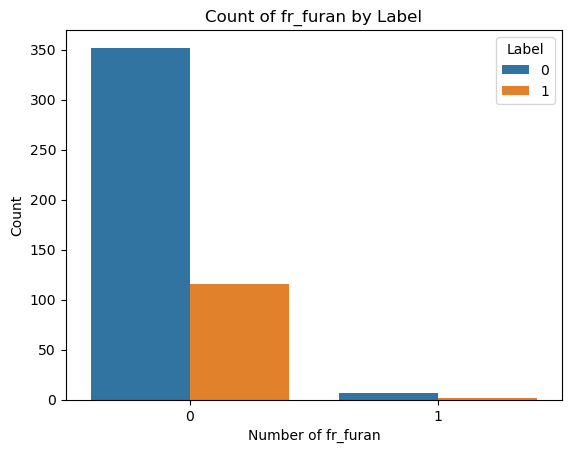

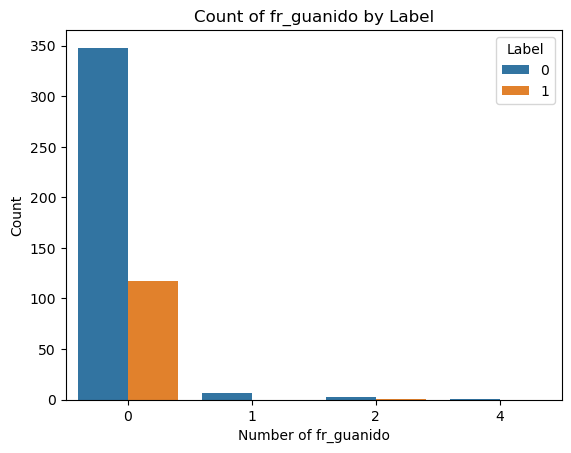

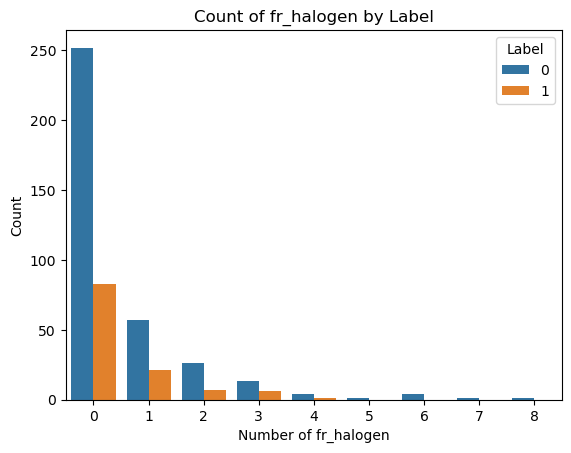

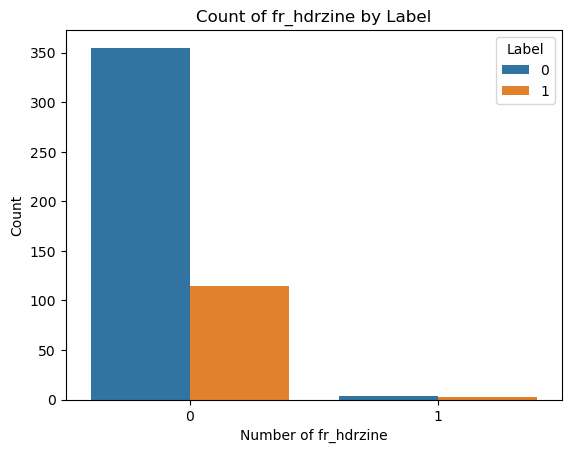

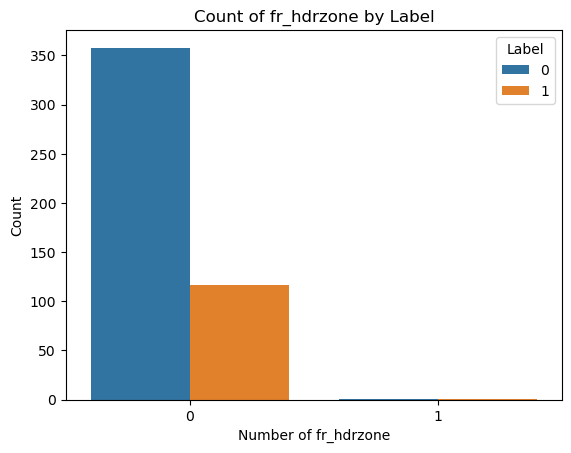

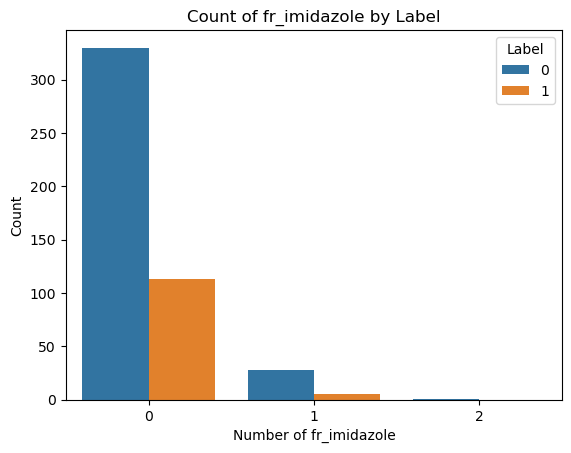

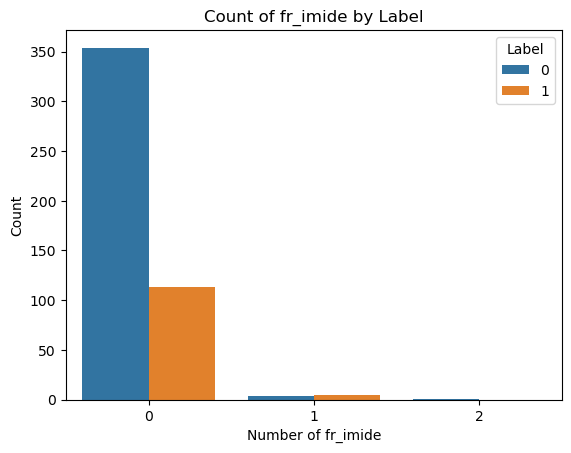

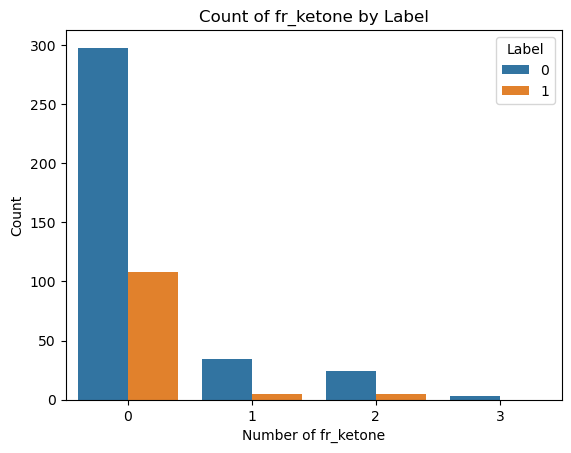

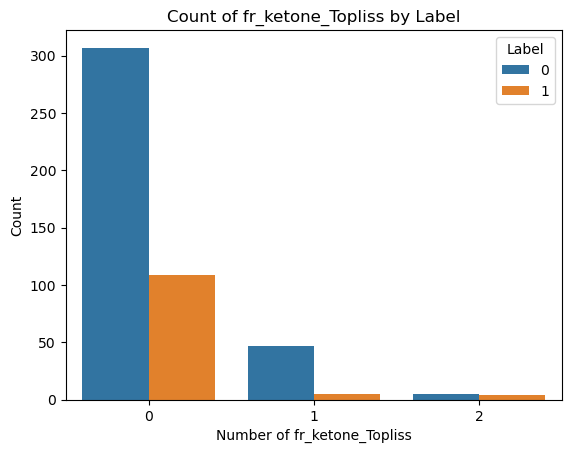

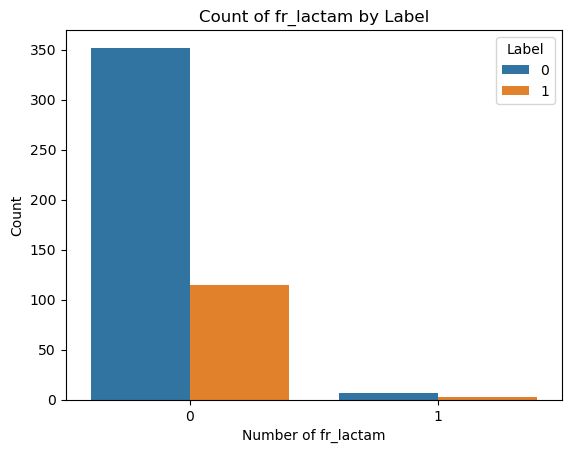

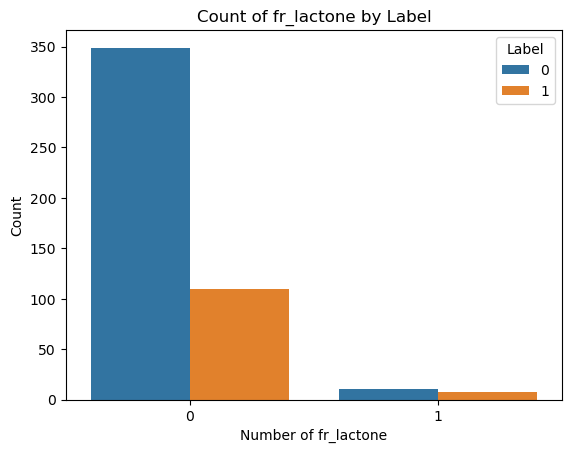

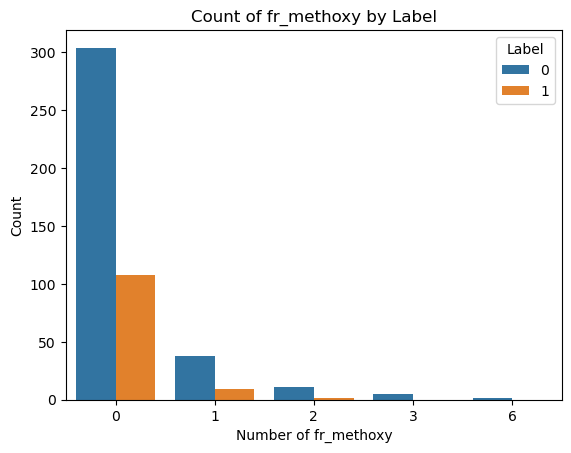

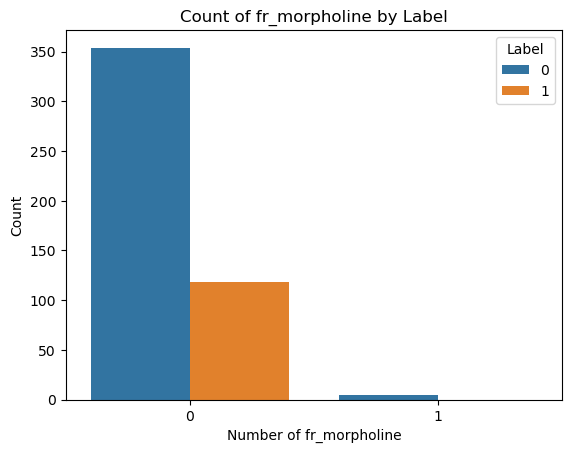

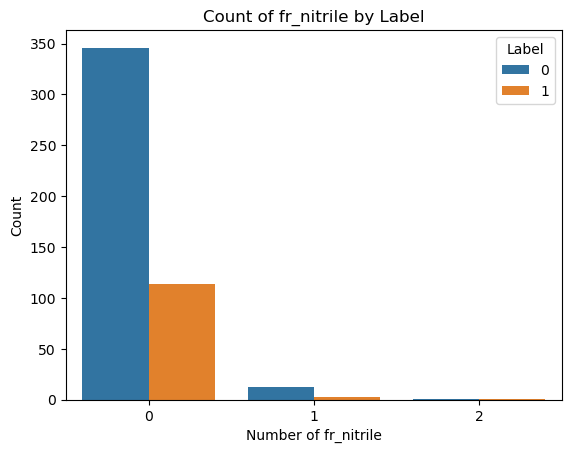

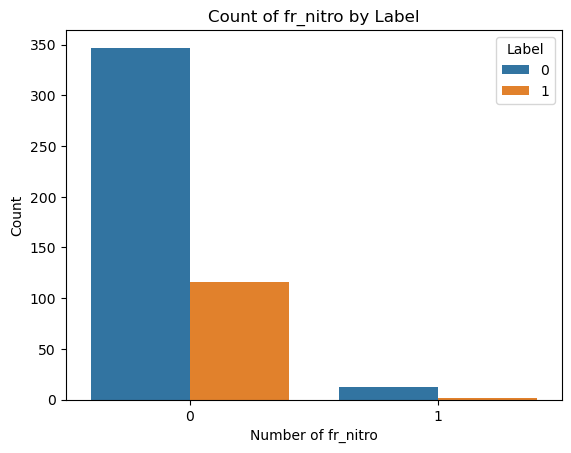

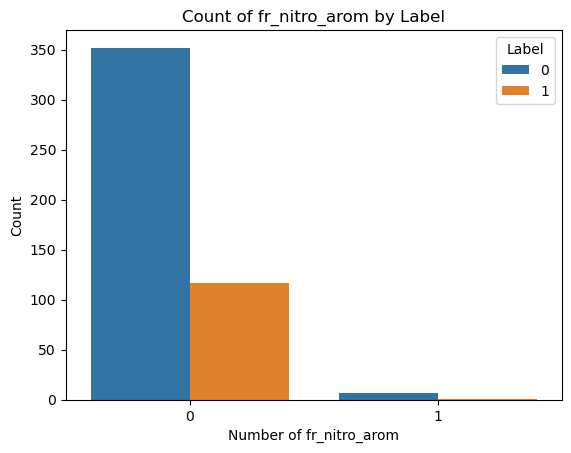

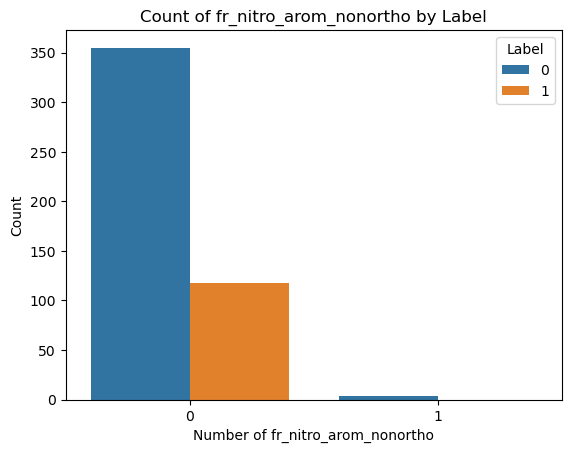

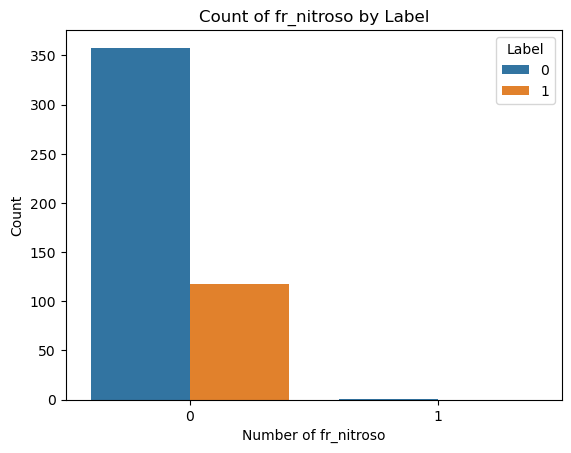

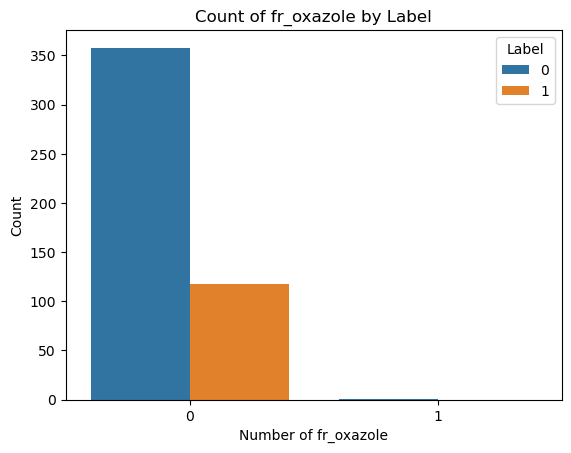

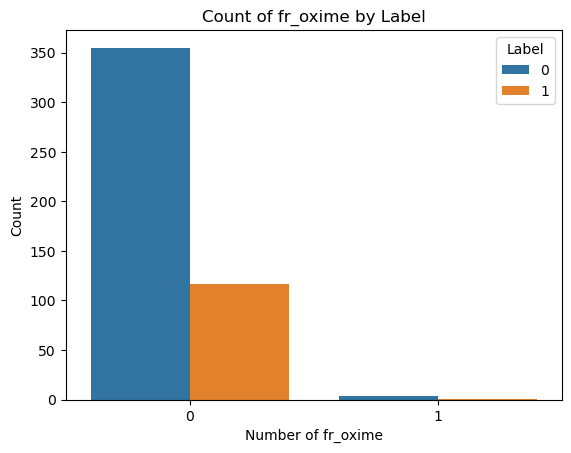

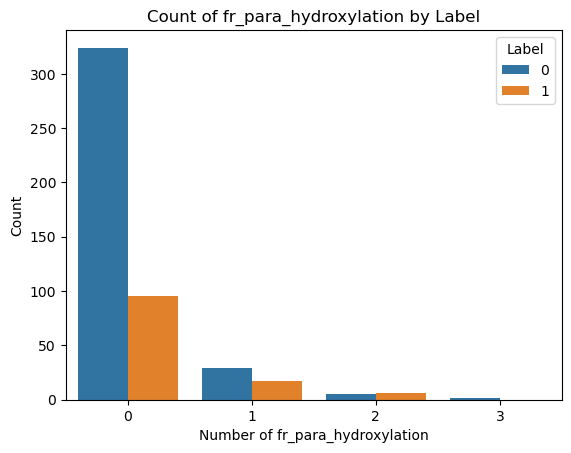

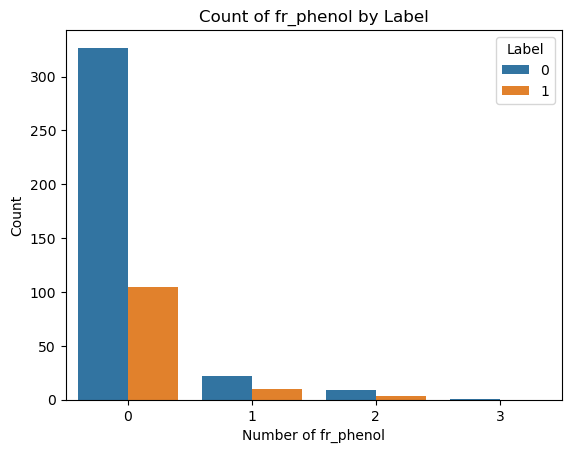

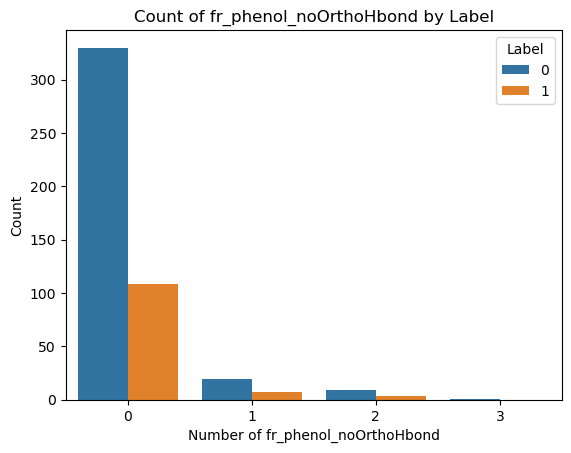

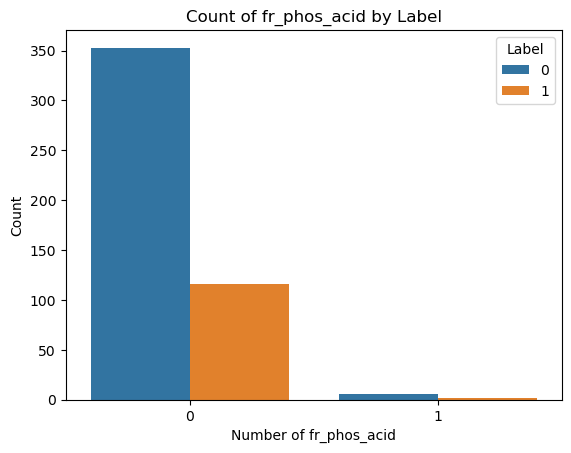

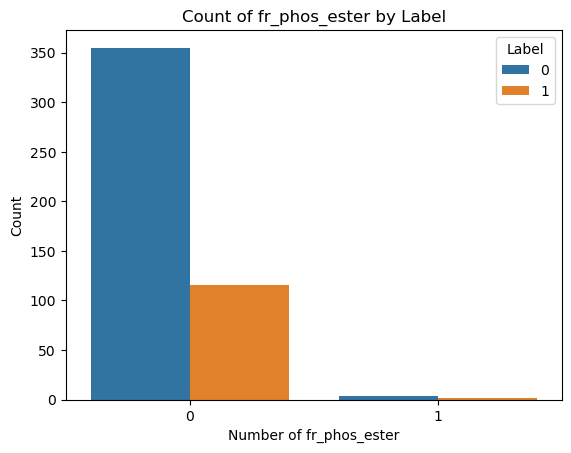

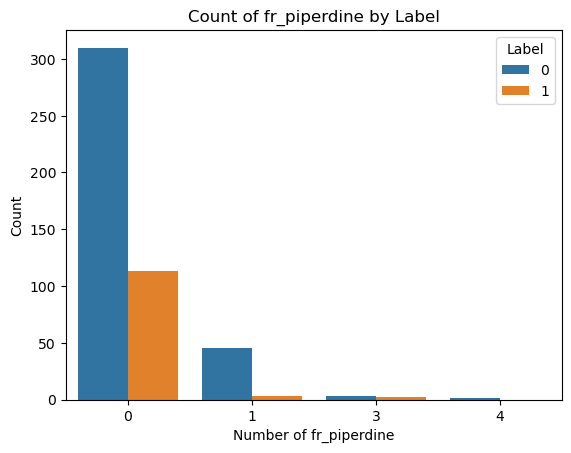

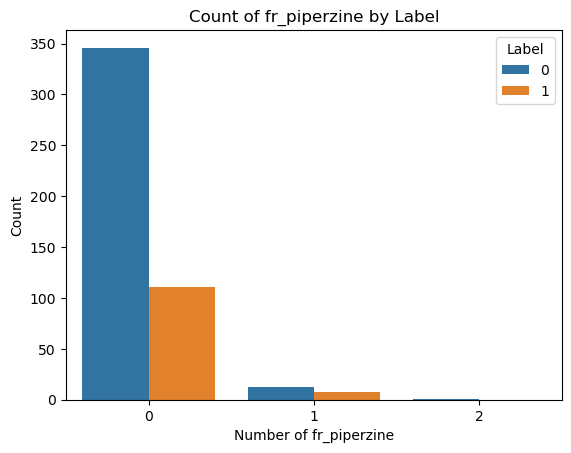

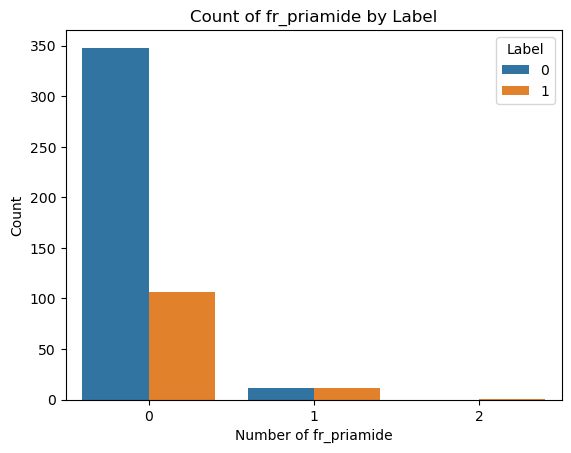

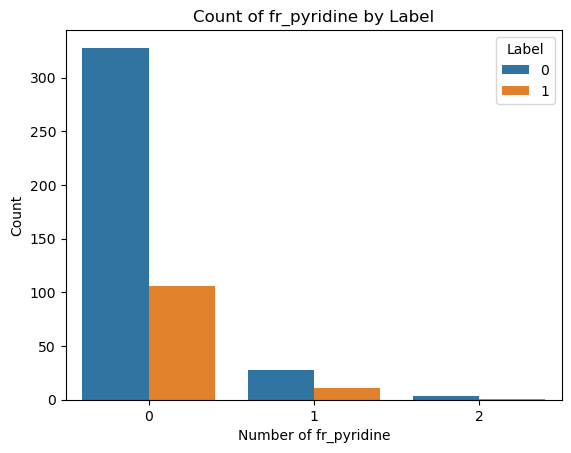

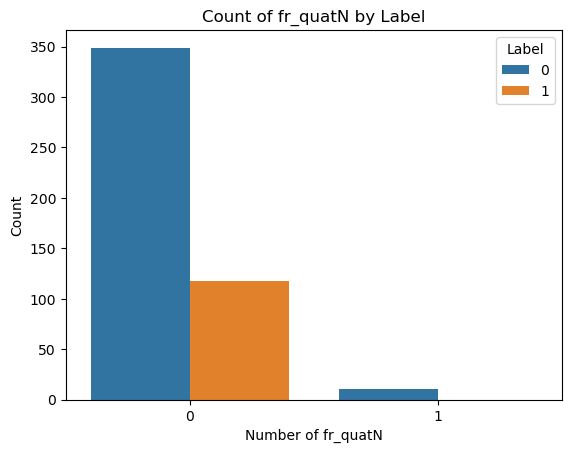

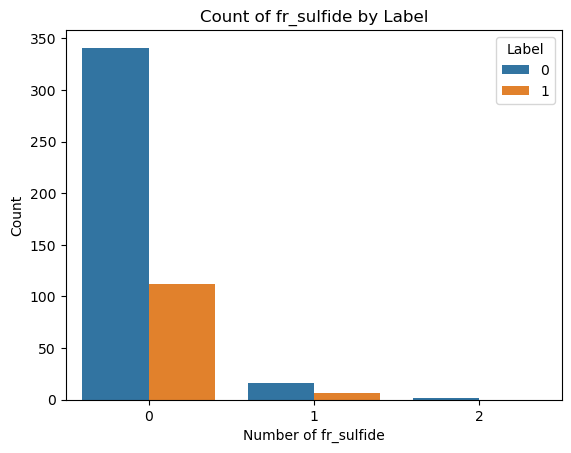

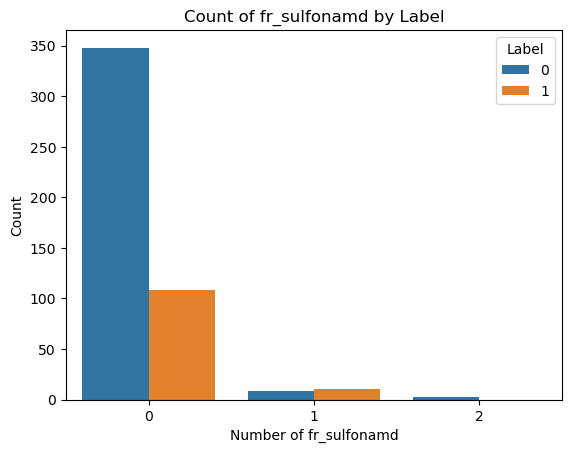

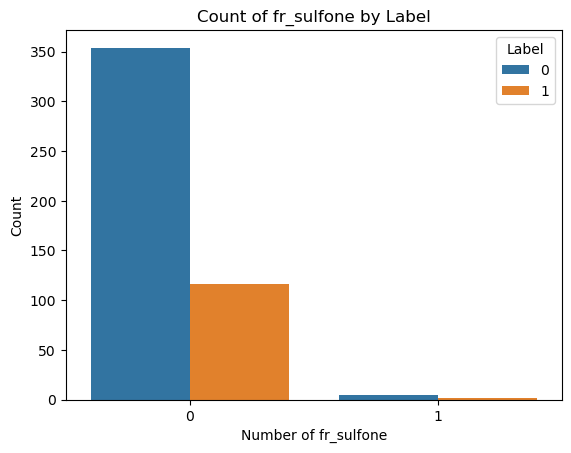

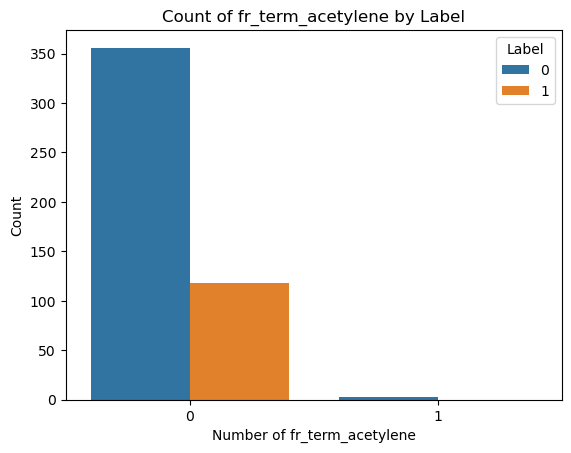

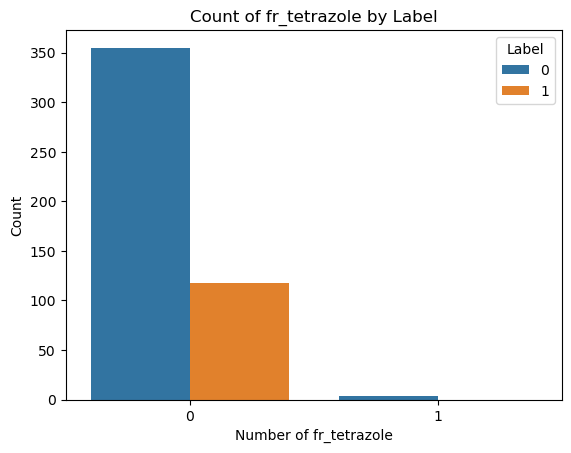

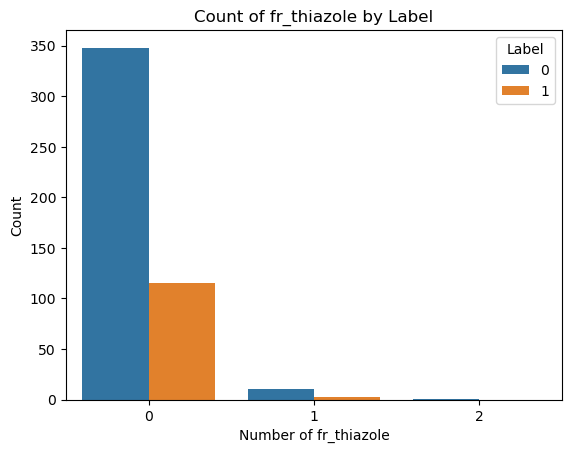

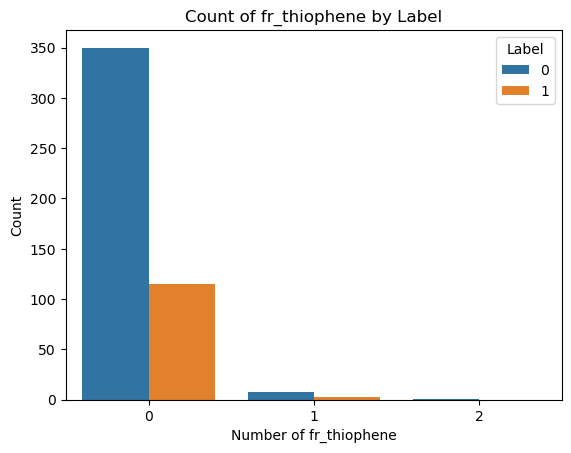

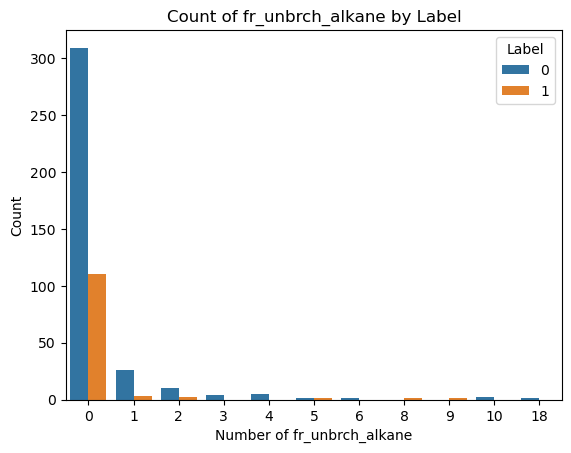

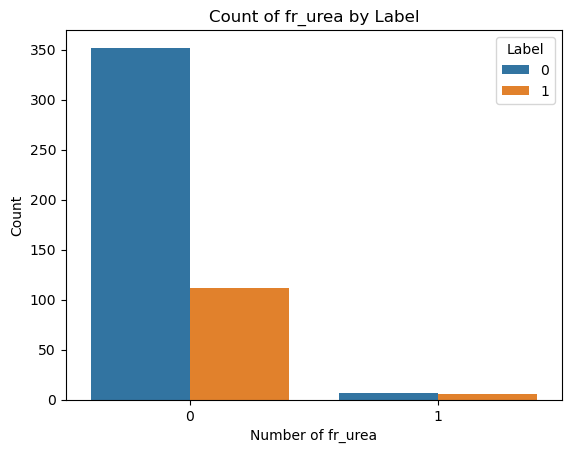

In [34]:
for col in fr_columns:
    sns.countplot(x=col, hue='Label', data=drug)
    plt.title(f'Count of {col} by Label')
    plt.xlabel(f'Number of {col}')
    plt.ylabel('Count')
    plt.legend(title='Label')
    plt.show()

In [35]:
#reading the test set, and applying the same data cleaning procedures on it to ensure consistency between train and test
test_set = pd.read_csv("DIA_testset_RDKit_descriptors.csv")

test_set = test_set.drop(columns='SMILES')

test_set = test_set.drop(columns=non_unique) #dropping all the columns that had no variation in training set

test_set.shape

(120, 180)

In [36]:
drug['Label'] = drug['Label'].astype('category')
drug['Label'].dtypes

CategoricalDtype(categories=[0, 1], ordered=False, categories_dtype=int64)

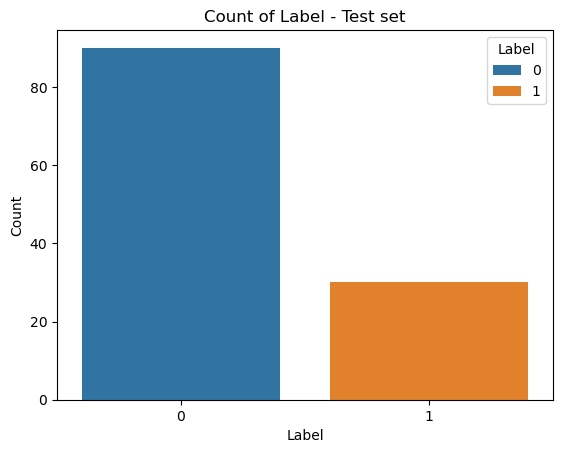

In [37]:
sns.countplot(x='Label', hue='Label', data=test_set)
plt.title('Count of Label - Test set')
plt.ylabel('Count')
plt.legend(title='Label')
plt.show()

In [38]:
test_set['Label'].value_counts()

Label
0    90
1    30
Name: count, dtype: int64

In [39]:
#making copies of training and testing for each of the classification model, to ensure the main data in unchanged

training_knn = drug.copy()
testing_knn = test_set.copy()

training_dt = drug.copy()
testing_dt = test_set.copy()

In [40]:
x_train = training_knn.drop(columns = ['Label'])
y_train = training_knn['Label']

x_test = testing_knn.drop(columns = ['Label'])
y_test = testing_knn['Label']

In [41]:
#since our data has varying magnitudes in different features, and knn is a distance based model, I am scaling the features
knn_scaler = StandardScaler()
X_train_s = knn_scaler.fit_transform(x_train)
X_test_s = knn_scaler.transform(x_test)

In [42]:
# initializing hill climbing for a random K, in this case k=3, code adopted from Lecture:Hill Climbing
new_index = []
max_score = 0
total_columns = X_train_s.shape[1]
index_random = shuffle(range(0,total_columns),random_state=1)

for col in range(0, total_columns):
    new_index.append(index_random[col])
    new_data = X_train_s[:,new_index]
    new_test_data = X_test_s[:,new_index]
    knn_model_2 = KNeighborsClassifier(n_neighbors=3)
    knn_model_2.fit(new_data, y_train)
    current_score = knn_model_2.score(new_test_data, y_test)
    if current_score < max_score:
        new_index.remove(index_random[col])
    else:
        max_score = current_score
        print(f"Score with {len(new_index)} selected features: {current_score}")

Score with 1 selected features: 0.75
Score with 2 selected features: 0.7583333333333333
Score with 3 selected features: 0.7583333333333333
Score with 4 selected features: 0.7666666666666667
Score with 5 selected features: 0.775
Score with 6 selected features: 0.7833333333333333
Score with 7 selected features: 0.7916666666666666
Score with 8 selected features: 0.8
Score with 9 selected features: 0.8083333333333333
Score with 10 selected features: 0.8083333333333333
Score with 11 selected features: 0.8166666666666667
Score with 12 selected features: 0.825
Score with 13 selected features: 0.825
Score with 14 selected features: 0.825
Score with 15 selected features: 0.8333333333333334


  File "C:\Users\Admin\anaconda3\Lib\site-packages\joblib\externals\loky\backend\context.py", line 257, in _count_physical_cores
    cpu_info = subprocess.run(
               ^^^^^^^^^^^^^^^
  File "C:\Users\Admin\anaconda3\Lib\subprocess.py", line 548, in run
    with Popen(*popenargs, **kwargs) as process:
         ^^^^^^^^^^^^^^^^^^^^^^^^^^^
  File "C:\Users\Admin\anaconda3\Lib\subprocess.py", line 1026, in __init__
    self._execute_child(args, executable, preexec_fn, close_fds,
  File "C:\Users\Admin\anaconda3\Lib\subprocess.py", line 1538, in _execute_child
    hp, ht, pid, tid = _winapi.CreateProcess(executable, args,
                       ^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^


Score with 16 selected features: 0.85
Score with 17 selected features: 0.8666666666666667
Score with 18 selected features: 0.8666666666666667
Score with 19 selected features: 0.8666666666666667
Score with 20 selected features: 0.8666666666666667
Score with 21 selected features: 0.8666666666666667
Score with 22 selected features: 0.875
Score with 23 selected features: 0.8833333333333333
Score with 24 selected features: 0.8833333333333333
Score with 25 selected features: 0.8833333333333333
Score with 26 selected features: 0.8916666666666667
Score with 27 selected features: 0.8916666666666667
Score with 28 selected features: 0.8916666666666667
Score with 29 selected features: 0.8916666666666667
Score with 30 selected features: 0.8916666666666667
Score with 31 selected features: 0.8916666666666667
Score with 32 selected features: 0.8916666666666667
Score with 33 selected features: 0.8916666666666667
Score with 34 selected features: 0.9
Score with 35 selected features: 0.9
Score with 36 sel

In [43]:
#since feature selection has now been done, we'll test for the optimum value of k
# but here we can see the bias, if we select features that were optimized for k=3, testing for other values of k would still give
# k = 3 as the highest accuracy
for k in range(1, 21):
    knn_model = KNeighborsClassifier(n_neighbors=k)
    knn_model.fit(X_train_s[:,new_index], y_train)
    y_pred = knn_model.predict(X_test_s[:,new_index])
    acc = accuracy_score(y_test, y_pred)
    print(f"k = {k}, Accuracy = {acc:.4f}")

k = 1, Accuracy = 0.8833
k = 2, Accuracy = 0.8500
k = 3, Accuracy = 0.9250
k = 4, Accuracy = 0.8333
k = 5, Accuracy = 0.8333
k = 6, Accuracy = 0.7833
k = 7, Accuracy = 0.8417
k = 8, Accuracy = 0.8083
k = 9, Accuracy = 0.8000
k = 10, Accuracy = 0.7917
k = 11, Accuracy = 0.7917
k = 12, Accuracy = 0.7833
k = 13, Accuracy = 0.7833
k = 14, Accuracy = 0.7917
k = 15, Accuracy = 0.7833
k = 16, Accuracy = 0.7833
k = 17, Accuracy = 0.7667
k = 18, Accuracy = 0.7750
k = 19, Accuracy = 0.7833
k = 20, Accuracy = 0.7833


In [44]:
#so within the above loop, we need to iteratively check for the best k, with its ideal features and accuracy
#and then save the value of K and its best features

total_columns = X_train_s.shape[1]
index_random = shuffle(range(0,total_columns),random_state=1)
ideal_features = None
g_score = 0

for k in range(1,11):
    new_index = []
    max_score = 0
    for col in range(0, total_columns):
        new_index.append(index_random[col])
        new_data = X_train_s[:,new_index]
        new_test_data = X_test_s[:,new_index]
        knn_model_2 = KNeighborsClassifier(n_neighbors=k)
        knn_model_2.fit(new_data, y_train)
        current_score = knn_model_2.score(new_test_data, y_test)
        if current_score < max_score:
            new_index.remove(index_random[col])
        else:
            max_score = current_score
            if g_score < max_score:
                g_score = max_score
                ideal_features = new_index
    print(f"Score with k = {k} and {len(new_index)} selected features: {max_score}")

Score with k = 1 and 52 selected features: 0.875
Score with k = 2 and 55 selected features: 0.9
Score with k = 3 and 62 selected features: 0.925
Score with k = 4 and 50 selected features: 0.8916666666666667
Score with k = 5 and 60 selected features: 0.9333333333333333
Score with k = 6 and 53 selected features: 0.8833333333333333
Score with k = 7 and 39 selected features: 0.8833333333333333
Score with k = 8 and 49 selected features: 0.85
Score with k = 9 and 36 selected features: 0.8333333333333334
Score with k = 10 and 56 selected features: 0.875


In [45]:
# so we can see from here, for k=5 and 60 features, the accuracy is the highest. We would now move to tuning parameters. 
print(ideal_features)
print(len(ideal_features))
print(g_score)

[114, 85, 160, 35, 124, 108, 125, 105, 11, 4, 14, 29, 84, 48, 31, 152, 90, 58, 39, 153, 173, 33, 158, 149, 91, 136, 113, 166, 45, 176, 132, 0, 77, 74, 126, 10, 34, 32, 83, 138, 123, 174, 159, 172, 150, 30, 163, 8, 175, 141, 50, 157, 139, 134, 129, 144, 79, 137, 140, 37]
60
0.9333333333333333


In [46]:
#for k = 5
knn_model = KNeighborsClassifier(n_neighbors=5)
knn_model.fit(X_train_s[:,ideal_features], y_train)
y_pred = knn_model.predict(X_test_s[:,ideal_features])

print(confusion_matrix(y_test, y_pred))
print(classification_report(y_test, y_pred))

[[90  0]
 [ 8 22]]
              precision    recall  f1-score   support

           0       0.92      1.00      0.96        90
           1       1.00      0.73      0.85        30

    accuracy                           0.93       120
   macro avg       0.96      0.87      0.90       120
weighted avg       0.94      0.93      0.93       120



In [47]:
# for k = 5 and weights = distance - choosing this
knn_model = KNeighborsClassifier(n_neighbors=5, weights='distance')
knn_model.fit(X_train_s[:,ideal_features], y_train)
y_pred = knn_model.predict(X_test_s[:,ideal_features])

print(confusion_matrix(y_test, y_pred))
print(classification_report(y_test, y_pred))

[[89  1]
 [ 7 23]]
              precision    recall  f1-score   support

           0       0.93      0.99      0.96        90
           1       0.96      0.77      0.85        30

    accuracy                           0.93       120
   macro avg       0.94      0.88      0.90       120
weighted avg       0.93      0.93      0.93       120



In [48]:
knn_model = KNeighborsClassifier(n_neighbors=5, weights='distance', p=1)
knn_model.fit(X_train_s[:,ideal_features], y_train)
y_pred = knn_model.predict(X_test_s[:,ideal_features])

print(confusion_matrix(y_test, y_pred))
print(classification_report(y_test, y_pred))

[[86  4]
 [13 17]]
              precision    recall  f1-score   support

           0       0.87      0.96      0.91        90
           1       0.81      0.57      0.67        30

    accuracy                           0.86       120
   macro avg       0.84      0.76      0.79       120
weighted avg       0.85      0.86      0.85       120



Decision Trees

In [50]:
# same procedure applied here as with knn, with varying max depth, to find the feature set with maximum accuracy
total_columns = X_train_s.shape[1]
index_random_dt = shuffle(range(0,total_columns),random_state=1)
ideal_features_dt = None
g_score_dt = 0
depth = [None,3,5,7]
for depth in depth:
    new_index_dt = []
    max_score_dt = 0
    for col in range(0, total_columns):
        new_index_dt.append(index_random_dt[col])
        new_data_dt = x_train.iloc[:,new_index_dt]
        new_test_data_dt = x_test.iloc[:,new_index_dt]
        clf = DecisionTreeClassifier(max_depth=depth,random_state=10)
        clf.fit(new_data_dt, y_train)
        current_score_dt = clf.score(new_test_data_dt, y_test)
        if current_score_dt < max_score_dt:
            new_index_dt.remove(index_random_dt[col])
        else:
            max_score_dt = current_score_dt
            if g_score_dt < max_score_dt:
                g_score_dt = max_score_dt
                ideal_features_dt = new_index_dt
    print(f"Score with depth = {depth} and {len(new_index_dt)} selected features: {max_score_dt}")

Score with depth = None and 15 selected features: 0.85
Score with depth = 3 and 43 selected features: 0.7833333333333333
Score with depth = 5 and 54 selected features: 0.8416666666666667
Score with depth = 7 and 21 selected features: 0.8833333333333333


In [51]:
print(len(ideal_features_dt))
print(g_score_dt)

21
0.8833333333333333


In [52]:
clf = DecisionTreeClassifier(max_depth=7,random_state=10)
clf.fit(x_train.iloc[:,ideal_features_dt], y_train)
y_pred_dt = clf.predict(x_test.iloc[:,ideal_features_dt])

print(confusion_matrix(y_test, y_pred_dt))
print(classification_report(y_test, y_pred_dt))

[[89  1]
 [13 17]]
              precision    recall  f1-score   support

           0       0.87      0.99      0.93        90
           1       0.94      0.57      0.71        30

    accuracy                           0.88       120
   macro avg       0.91      0.78      0.82       120
weighted avg       0.89      0.88      0.87       120



In [53]:
# min sample leaf left as default
leaf = [1,2,3,5,7,9]

for leaf in leaf:
    clf = DecisionTreeClassifier(max_depth=7, min_samples_leaf=leaf, random_state=10)
    clf.fit(x_train.iloc[:,ideal_features_dt], y_train)
    y_pred_dt = clf.predict(x_test.iloc[:,ideal_features_dt])
    print(f"\nMin Samples Leaf: {leaf}")
    print(classification_report(y_test, y_pred_dt, digits=2))


Min Samples Leaf: 1
              precision    recall  f1-score   support

           0       0.87      0.99      0.93        90
           1       0.94      0.57      0.71        30

    accuracy                           0.88       120
   macro avg       0.91      0.78      0.82       120
weighted avg       0.89      0.88      0.87       120


Min Samples Leaf: 2
              precision    recall  f1-score   support

           0       0.84      0.99      0.91        90
           1       0.93      0.43      0.59        30

    accuracy                           0.85       120
   macro avg       0.88      0.71      0.75       120
weighted avg       0.86      0.85      0.83       120


Min Samples Leaf: 3
              precision    recall  f1-score   support

           0       0.85      0.98      0.91        90
           1       0.88      0.47      0.61        30

    accuracy                           0.85       120
   macro avg       0.86      0.72      0.76       120
weighted av

In [54]:
clf = DecisionTreeClassifier(max_depth=7,random_state=10, max_features='sqrt')
clf.fit(x_train.iloc[:,ideal_features_dt], y_train)
y_pred_dt = clf.predict(x_test.iloc[:,ideal_features_dt])

print(confusion_matrix(y_test, y_pred_dt))
print(classification_report(y_test, y_pred_dt))

[[88  2]
 [21  9]]
              precision    recall  f1-score   support

           0       0.81      0.98      0.88        90
           1       0.82      0.30      0.44        30

    accuracy                           0.81       120
   macro avg       0.81      0.64      0.66       120
weighted avg       0.81      0.81      0.77       120



In [55]:
# max_features also left at default
clf = DecisionTreeClassifier(max_depth=7,random_state=10, max_features='log2')
clf.fit(x_train.iloc[:,ideal_features_dt], y_train)
y_pred_dt = clf.predict(x_test.iloc[:,ideal_features_dt])

print(confusion_matrix(y_test, y_pred_dt))
print(classification_report(y_test, y_pred_dt))

[[88  2]
 [21  9]]
              precision    recall  f1-score   support

           0       0.81      0.98      0.88        90
           1       0.82      0.30      0.44        30

    accuracy                           0.81       120
   macro avg       0.81      0.64      0.66       120
weighted avg       0.81      0.81      0.77       120



In [56]:
# criterion gini selected
clf = DecisionTreeClassifier(criterion='entropy',max_depth=7,random_state=10)
clf.fit(x_train.iloc[:,ideal_features_dt], y_train)
y_pred_dt = clf.predict(x_test.iloc[:,ideal_features_dt])

print(confusion_matrix(y_test, y_pred_dt))
print(classification_report(y_test, y_pred_dt))

[[89  1]
 [16 14]]
              precision    recall  f1-score   support

           0       0.85      0.99      0.91        90
           1       0.93      0.47      0.62        30

    accuracy                           0.86       120
   macro avg       0.89      0.73      0.77       120
weighted avg       0.87      0.86      0.84       120

